# This notebook will analyze raw spike data from recorded sessions in the experiments outlined in Rolon-Martinez, et. al (2024).

## Functions and Plotting Parameters

### Import packages you will need for running this script ##

In [4]:
import os
import numpy as np
import numpy.matlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, LinearLocator, FormatStrFormatter
import scipy as scipy
from scipy import io
from scipy import signal
from scipy.io import loadmat
from scipy.stats import wilcoxon
from scipy import stats
from glob import glob
import pandas as pd
import matplotlib.cm as cm
from datetime import datetime
import cmasher as cmr
import matplotlib.ticker as ticker
from sklearn import linear_model
from sklearn.impute import SimpleImputer
import warnings

import seaborn as sns


# Global Plotting Parameters

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.size'] = 8
mpl.rcParams.update({'mathtext.default':  'regular' })
# mpl.rcParams['figure.figsize']: (0.67,0.5)
mpl.rcParams['figure.titlesize'] = 8
mpl.rcParams['figure.autolayout']: True
mpl.rcParams['figure.constrained_layout.use'] = True
    
mpl.rcParams['savefig.dpi'] = 600
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.transparent'] = True

mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['xaxis.labellocation'] = 'center'
mpl.rcParams['yaxis.labellocation'] = 'center'
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['axes.titlepad'] = 4

mpl.rcParams['lines.linewidth'] = 0.5

mpl.rcParams['legend.loc']='upper left'
mpl.rcParams['legend.frameon']= False
mpl.rcParams['legend.fontsize']= 6

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

mpl.rcParams['xtick.labelsize']= 6
mpl.rcParams['ytick.labelsize']= 6

mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = .5
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = .5
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1

mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.minor.width'] = .5
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.minor.width'] = .5
mpl.rcParams['xtick.minor.pad'] = 1
mpl.rcParams['ytick.minor.pad'] = 1

_new_black = '#373737'
mpl.rcParams['lines.color'] = _new_black
mpl.rcParams['patch.edgecolor'] = _new_black
mpl.rcParams['patch.force_edgecolor'] = False
mpl.rcParams['boxplot.flierprops.color'] = _new_black
mpl.rcParams['boxplot.flierprops.markeredgecolor'] = _new_black
mpl.rcParams['boxplot.boxprops.color'] = _new_black
mpl.rcParams['boxplot.whiskerprops.color'] = _new_black
mpl.rcParams['boxplot.capprops.color'] = _new_black
mpl.rcParams['boxplot.capprops.linewidth'] = 0.5
mpl.rcParams['text.color'] = _new_black
mpl.rcParams['axes.edgecolor'] = _new_black
mpl.rcParams['axes.labelcolor'] = _new_black
mpl.rcParams['xtick.color'] = _new_black
mpl.rcParams['ytick.color'] = _new_black

### Functions for running data analysis ###

In [6]:
def load_npy_files(data_loc, subfolder, filename):
    return np.load(os.path.join(data_loc, subfolder, filename))

def read_sync_messages(data_loc):
    sync_messages_path = os.path.join(data_loc, 'sync_messages.txt')
    try:
        with open(sync_messages_path, 'r') as file:
            for last_line in file:
                pass
    except FileNotFoundError:
        print(f"File {sync_messages_path} not found.")
        return None, None
    
    start_time, sample_rate = map(int, last_line.split('@'))
    sample_rate = sample_rate[:-2]  # Remove Hz from sample rate string
    return start_time, sample_rate

def convert_to_seconds(samples, start_time, fs):
    return (samples - start_time) / fs

def select_block_events(events_timestamps, event_states, block_start, block_end=None):
    if block_end is None:
        indices = events_timestamps > block_start
    else:
        indices = (events_timestamps > block_start) & (events_timestamps < block_end)
    return events_timestamps[indices], event_states[indices]

def load_cluster_info(data_loc):
    clust_info = pd.read_csv(os.path.join(data_loc, 'cluster_info.tsv'), delimiter='\t')
    return clust_info[clust_info.group != 'noise']

def load_mean_waveforms(data_loc):
    mean_waves = loadmat(os.path.join(data_loc, 'mean_waveforms.mat'))
    ycoords = mean_waves['chanMap']['ycoords'][0][0][0]
    mn = np.squeeze(mean_waves['mn']) - 1  # Adjusting MATLAB's 1-based indexing
    clust_depth = ycoords[mn]
    max_depth = np.max(mean_waves['chanMap']['ycoords'][0][0][0])
    clust_depth = np.int32(clust_depth) - np.int32(max_depth)
    return clust_depth

def get_events(data_loc):
    msg_text = load_npy_files(data_loc, 'messages', 'text.npy')
    msg_sample = load_npy_files(data_loc, 'messages', 'timestamps.npy')
    ev_state = load_npy_files(data_loc, 'events', 'channel_states.npy')
    ev_sample = load_npy_files(data_loc, 'events', 'timestamps.npy')
    start_time, fs = read_sync_messages(data_loc)
    
    if start_time is None or fs is None:
        return None
    
    ev_ts = convert_to_seconds(ev_sample, start_time, fs)
    msg_ts = convert_to_seconds(msg_sample, start_time, fs)
    
    print(*msg_text, sep='\n')
    print("Total number of blocks:", len(msg_ts))
    block_start_id = int(input("Indicate Block Start here (remember python syntax where 0 = 1): "))
    block_start = msg_ts[block_start_id]
    
    if block_start_id + 1 >= len(msg_ts):
        block_end = None
    else:
        block_end = msg_ts[block_start_id + 1]
    
    block_ev_ts, block_ev_state = select_block_events(ev_ts, ev_state, block_start, block_end)
    
    spikes = load_npy_files(data_loc, '', 'spike_times.npy') / fs
    clust = load_npy_files(data_loc, '', 'spike_clusters.npy')
    clust_info = load_cluster_info(data_loc)
    clust_depth = load_mean_waveforms(data_loc)
    
    stimulus_on = block_ev_ts[block_ev_state == 1][1:]  # Assuming the first event is not a stimulus onset
    stimulus_off = block_ev_ts[block_ev_state == -1][1:]  # Assuming the first event is not a stimulus offset
    
    return ev_state, ev_ts, msg_ts, block_ev_ts, stimulus_on, spikes, clust, clust_depth, clust_info, stimulus_off

In [9]:
# This function applies a smoothing guassian filter to your data
def SmoothGauss(X, M):
    if X.ndim != 1:
        raise ValueError("X must be a 1D array.")
    
    sigma = M ** 0.5
    G = np.arange(-M, M+1)
    F = np.exp(-G**2 / ((2 * sigma)**2))
    F /= np.sum(F)
    Y = np.convolve(X, F, mode='full')
    
    start_index = M
    end_index = start_index + len(X)
    Y = Y[start_index:end_index]
    
    correction_start = np.sum(F) / (np.sum(F[:M]) + np.cumsum(F[M:M*2]))
    correction_end = np.sum(F) / (np.sum(F[:M]) + np.cumsum(F[M:M*2])[::-1])
    
    Y[:M] *= correction_start
    Y[-M:] *= correction_end
    
    return Y


# This function extracts spikes and returns your raster, trials and psth variable:
def spike_data(spikes, stimulusOnset, edges, smVar):
    raster = []
    trials = []
    psth = np.empty(([len(stimulusOnset), len(edges)-1]))
    psth_S = np.empty(([len(stimulusOnset), len(edges)-1]))
    
    for s, stim in enumerate (stimulusOnset):
        
        spks = spikes - stim
        
        psth[s,:], _ = np.histogram(spks, bins=edges)
        psth[s,:] = psth[s,:]/np.diff(edges).mean()
        psth_S[s,:] = SmoothGauss(psth[s,:],smVar)
        
        spks = spks[(spks > edges[0]) & (spks < edges[-1])]
        raster.extend(spks)
        trials.extend(np.ones(len(spks))*(s+1))
        
    return raster, trials, psth, psth_S

In [11]:
def load_stim_info(stim_loc, file_name, extract_fields=None):
    """
    Load stimulus information from a MATLAB file, handling multi-dimensional arrays appropriately.

    Parameters:
    - stim_loc: The directory where the stimulus file is located.
    - file_name: The name of the MATLAB file containing the stimulus information.
    - extract_fields: Optional list of fields to extract from the stimulus information.
                      If None, all fields are extracted.

    Returns:
    - A dictionary containing the requested stimulus information, or all information if extract_fields is None.
    - The name of the file.
    """
    full_path = os.path.join(stim_loc, file_name)
    try:
        file = loadmat(full_path, appendmat=True)
        stim_inf = file['stimInfo'][0, 0]
        stim_info = {}
        
        # If no specific fields are requested, extract all.
        if extract_fields is None:
            extract_fields = stim_inf.dtype.names
        
        for field in extract_fields:
            if field in stim_inf.dtype.names:
                # Handling multi-dimensional arrays without converting to scalar
                value = stim_inf[field]
                if value.size == 1:
                    stim_info[field] = value.item()  # For single elements, convert to scalar
                else:
                    stim_info[field] = value  # Keep as array for multi-dimensional data
            else:
                print(f"Warning: '{field}' not found in stimulus information.")
        
        return stim_info, file_name
    except FileNotFoundError:
        print(f"Error: File '{full_path}' not found.")
        return None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

def get_stimulus_info(stim_loc, main_stim_file, laser_stim_file, nreps, nreps_laser, extract_fields=None):
    main_stim_info, _ = load_stim_info(stim_loc, main_stim_file + '.mat', extract_fields)
    if main_stim_info is None:
        print(f"Failed to load main stimulus information from {main_stim_file}")
        return None

    laser_stim_info, _ = load_stim_info(stim_loc, laser_stim_file + '.mat', extract_fields)
    if laser_stim_info is None:
        print(f"Failed to load laser stimulus information from {laser_stim_file}")
        return None

    # Direct extraction of necessary information without duplication
    return {
        "ITI_laser": laser_stim_info.get('ITI', None),
        "laserOnlyDur": laser_stim_info.get('laserDur', None),
        "ITI": main_stim_info.get('ITI', None),
        "laserDur": main_stim_info.get('laserDur', None),
        "tDur": main_stim_info.get('tDur', None),
        "trialOrder_main": main_stim_info.get('trialOrder', [])
    }

In [13]:
def load_probe_data(excel_path, cell_type, virus):
    # Assuming each sheet corresponds to a different cell type or there's a naming pattern
    sheet_name = f'{cell_type}_{virus}_Depths'
    return pd.read_excel(excel_path, sheet_name=sheet_name)

def load_and_concatenate_npz(directory, stim):
    files = sorted(glob(os.path.join(directory, f'*{stim}.npz')))
    all_data = [np.load(f, allow_pickle=True) for f in files]
    
    fullpsth = np.concatenate([data['allPSTH'] for data in all_data if 'allPSTH' in data.files], axis=2)
    fullpsthS = np.concatenate([data['allPSTH_S'] for data in all_data if 'allPSTH_S' in data.files], axis=2)
    
    clustdepth = []
    rasters = []
    trials = []
    spikesortind = []
    session_mapping = {}
    current_index = 0
    
    for idx, data in enumerate(all_data):
        session_id = os.path.basename(files[idx]).split(' ')[2]  # Adjust according to filename format
        if 'clustDepth' in data.files and data['clustDepth'].size > 0:
            clust_depth_data = [(depth, session_id) for depth in data['clustDepth'].tolist()]
            clustdepth.extend(clust_depth_data)
            
            session_mapping[session_id] = (current_index, current_index + len(clust_depth_data))
            current_index += len(clust_depth_data)
        
        if 'rasters' in data.files and data['rasters'].size > 0:
            rasters.extend(data['rasters'].tolist())
        
        if 'trials' in data.files and data['trials'].size > 0:
            trials.extend(data['trials'].tolist())
        
        if 'spikeSortI' in data.files and data['spikeSortI'].size > 0:
            spikesortind.extend(data['spikeSortI'].tolist())
    
    clustdepth = np.array(clustdepth, dtype=object)
    rasters = np.array(rasters, dtype=object)
    trials = np.array(trials, dtype=object)
    spikesortind = np.array(spikesortind, dtype=object) if spikesortind else None
    
    return fullpsth, fullpsthS, clustdepth, rasters, trials, spikesortind, session_mapping


def summarize_data(rasters, spikesortind, clustdepth, fullpsth, fullpsthS, fullpsth_L, fullpsthS_L):
    """
    Summarize the dimensions and shapes of key experimental data arrays.

    Parameters:
    - Rasters: Raster plot data.
    - SpikeSortInd: Spike sorting index.
    - Clust_Depth: Cluster depth information.
    - FullPSTH: Full peri-stimulus time histogram.
    """
    print("Data Summary:")
    print("-------------")
    print(f"Length of Rasters: {len(rasters)}")
    print(f"Length of SpikeSortInd: {len(spikesortind)}")
    print(f"Length of Clust_Depth: {len(clustdepth)}")
    print(f"Shape of FullPSTH: {fullpsth.shape}")
    print(f"Shape of Smoothed FullPSTH: {fullpsthS.shape}")
    print(f"Shape of FullPSTH_Laser: {fullpsth_L.shape}")
    print(f"Shape of Smoothed FullPSTH_Laser: {fullpsthS_L.shape}")

In [15]:
def load_experiment_data(data_path, main_stim_file, data_path_laser, laser_stim_file, stim_loc, nreps, nreps_laser):
    binSize = .002  
    edges = np.arange(-.050, .20, binSize)
    time = edges[:-1]

    FullPSTH, FullPSHT_S, Clust_Depth, Rasters, Trials, SpikeSortInd, Session_Map = load_and_concatenate_npz(data_path,
                                                                                                             main_stim_file.replace(".mat", ""))
    
    FullPSTH_Laser, FullPSHT_S_Laser, Clust_Depth_laser, Rasters_laser, Trials, SpikeSortInd_laser, Session_Map_Laser = load_and_concatenate_npz(data_path_laser, laser_stim_file.replace(".mat", ""))
    
    stim_info = get_stimulus_info(stim_loc, main_stim_file, laser_stim_file, nreps, nreps_laser)
    
    # Repetition of trialOrder calculation is now removed and directly fetched from stim_info
    trialOrder = np.matlib.repmat(stim_info['trialOrder_main'], nreps, 1)
    ITI, ITI_laser = stim_info['ITI'], stim_info['ITI_laser']
    laserDur, laserOnlyDur = stim_info['laserDur'], stim_info['laserOnlyDur']
    tDur = stim_info['tDur']

    
    return FullPSTH, FullPSHT_S, Clust_Depth, Rasters, Trials, SpikeSortInd, FullPSTH_Laser, FullPSHT_S_Laser, trialOrder, ITI, ITI_laser, laserDur, laserOnlyDur, tDur, binSize, edges, time , Session_Map, Session_Map_Laser

In [17]:
def ismember(A, B):
    A = np.asarray(A).astype(int)
    B = np.asarray(B).astype(int)
    res = np.zeros(A.shape)
    for i in np.unique(A):
        res[A == i] = np.argwhere(B == i).squeeze()
    return res

In [19]:
def map_cluster_depths_to_real_dimensions(clust_depth, probe_data):
    real_depths = []
    
    for depth_info in clust_depth:
        depth, session_id = depth_info  # Unpacking depth and session ID from each tuple
        # Get the probe start depth for this session from the probe data
        session_probe_data = probe_data[probe_data['Recording Session'] == session_id]
        if not session_probe_data.empty:
            probe_start = session_probe_data['Probe_Start'].iloc[0]

            # Convert the clust_depth value for this session
            # Since clust_depth value is below the start of the probe, convert from µm to mm and adjust from the start
            real_depth = round(probe_start - (depth / 1000), 3)
            real_depths.append((real_depth, session_id))
        else:
            # If no corresponding probe data, use None for depth and keep session ID
            real_depths.append((None, session_id))

    return real_depths

In [21]:
def normalize_psth_data(data, laser_off_indices, laser_on_indices, axis=0):
    """
    Calculate the mean for 'laserOn' and 'laserOff' conditions for each cell and normalize the 'laserOn' mean 
    to the range derived from the 'laserOff' mean.
    
    Parameters:
    - data: numpy array, the PSTH data with dimensions that can vary.
    - laser_off_indices: numpy array or list, indices indicating the laser off condition.
    - laser_on_indices: numpy array or list, indices indicating the laser on condition.
    - axis: int, the axis along which the means are calculated and conditions are defined.
    
    Returns:
    - norm_mean_off: numpy array, normalized mean data for the 'laserOff' condition.
    - norm_mean_on: numpy array, normalized mean data for the 'laserOn' condition to the 'laserOff' range.
    """
    # Calculate means across the specified axis for both conditions
    mean_off = np.take(data, laser_off_indices, axis=axis).mean(axis=axis)
    mean_on = np.take(data, laser_on_indices, axis=axis).mean(axis=axis)
    
    # Calculate normalization parameters based on the 'laserOff' mean
    min_off = np.min(mean_off, axis=0, keepdims=True)
    max_off = np.max(mean_off, axis=0, keepdims=True)
    
    # Normalize both 'laserOff' and 'laserOn' mean data to the 'laserOff' mean range
    norm_mean_off = (mean_off - min_off) / np.where(max_off != min_off, max_off - min_off, 1)
    norm_mean_on = (mean_on - min_off) / np.where(max_off != min_off, max_off - min_off, 1)
    
    return norm_mean_off, norm_mean_on


# Define the modified function to handle NaN values
def calculate_sem(data):
    """Calculate the Standard Error of the Mean (SEM) along the specified axis, ignoring NaNs."""
    return np.nanstd(data, axis=1) / np.sqrt(np.sum(~np.isnan(data), axis=1))

In [23]:
def normalize_to_laserOff_TC(data1, data2):
    norm_data1 = np.empty(data1.shape)
    norm_data2 = np.empty(data2.shape)
    
    for cell in range(data1.shape[1]):
        min_data1 = np.min(data1[:, cell])
        max_data1 = np.max(data1[:, cell])
        
        # Normalize data1 to its own range
        norm_data1[:, cell] = (data1[:, cell] - min_data1) / (max_data1 - min_data1)
        
        # Normalize data2 to the range of data1
        norm_data2[:, cell] = (data2[:, cell] - min_data1) / (max_data1 - min_data1)
    
    return norm_data1, norm_data2

def calculate_mTC(data, tones, freqs):
    mTC = np.zeros((len(freqs), data.shape[1]))
    for uniq in range(len(freqs)):
        mTC[uniq, :] = data[tones == freqs[uniq], :].mean(axis=0)
    return mTC

def calculate_psthTC(PSTH, tonescond1, tonescond2, freqs, lasercond1, lasercond2):
    num_uniq = len(freqs)
    time_points = PSTH.shape[1]
    num_cells = PSTH.shape[2]
    psthTC1 = np.zeros((num_uniq, time_points, num_cells))
    psthTC2 = np.zeros((num_uniq, time_points, num_cells))

    for uniq in range(num_uniq):
        toneTrial1 = PSTH[lasercond1, :, :][tonescond1 == freqs[uniq]]
        toneTrial_2 = PSTH[lasercond2, :, :][tonescond2 == freqs[uniq]]
        psthTC1[uniq, :, :] = toneTrial1.mean(axis=0)
        psthTC2[uniq, :, :] = toneTrial_2.mean(axis=0)

    return psthTC1, psthTC2

def fit_and_predict(TC1, TC2):
  
    slope = np.zeros(TC1.shape[1])
    intercept = np.zeros(TC1.shape[1])
    y_preds = np.zeros_like(TC1)
    
    for cell in range(TC1.shape[1]):
        from sklearn.linear_model import LinearRegression
        model = LinearRegression(fit_intercept=True)
        modelfit = model.fit(TC1[:, cell].reshape((-1, 1)), TC2[:, cell])
        slope[cell] = modelfit.coef_[0]  # Extract the first element 
        intercept[cell] = modelfit.intercept_
        y_preds[:, cell] = modelfit.predict(TC1[:, cell].reshape((-1, 1)))
    return slope, intercept, y_preds

def calculate_sparseness(*conditions):
   
    def calc_sparseness(resp):
        N = len(resp)
        a = ((np.sum(resp)/N)**2) / np.sum((resp**2)/N)
        s = (1-a) / (1 - (1/N))
        return s
    
    results = []
    for condition in conditions:
        sparseness_values = [calc_sparseness(condition[:, cell]) for cell in range(condition.shape[1])]
        results.append(sparseness_values)
    
    return results

In [25]:
def find_time_to_peak(peak_data_off, peak_data_on, edges_early_evoked_Ind, spontInd):
    t2pOff, t2pOn = [], []
    for cell in range(len(peak_data_on[0])):
        bOff, _ = signal.find_peaks(peak_data_off[early_evoked_Ind, cell], height=(
            np.mean(peak_data_off[spontInd, cell]) +
            (np.std(peak_data_off[spontInd, cell]) * 3)))
        bOn, _ = signal.find_peaks(peak_data_on[early_evoked_Ind, cell], height=(
            np.mean(peak_data_on[spontInd, cell]) +
            (np.std(peak_data_on[spontInd, cell]) * 3)))

        if bOff.size > 0:
            i_max_peak_Off = bOff[np.argmax(peak_data_off[early_evoked_Ind, cell][bOff])]
            x_max_Off = edges[edges_early_evoked_Ind][i_max_peak_Off]
            t2pOff.append(x_max_Off)
        else:
            t2pOff.append(np.nan)  # Handle case where no peak is found
        
        if bOn.size > 0:
            i_max_peak_On = bOn[np.argmax(peak_data_on[early_evoked_Ind, cell][bOn])]
            x_max_On = edges[edges_early_evoked_Ind][i_max_peak_On]
            t2pOn.append(x_max_On)
        else:
            t2pOn.append(np.nan)  # Handle case where no peak is found

    return t2pOff, t2pOn

In [27]:
def get_BF_and_uBF(off_responses, on_responses, freqs, side_freq):
    # Nested function to process contextual responses
    def process_contextual_responses(i, freqs_array, freqs, side_freq, off_responses, on_responses, off_context_resp, on_context_resp):
        freq_index = np.argwhere(freqs_array[i] == freqs).flatten()[0]
        nearby_indices = np.arange(freq_index - side_freq, freq_index + side_freq + 1).astype('float')
        nearby_indices[np.logical_or(nearby_indices < 0, nearby_indices >= len(freqs))] = np.NaN

        off_context_resp[:, i] = np.nan
        valid = ~np.isnan(nearby_indices)
        valid_indices = nearby_indices[valid].astype(int)
        off_context_resp[valid, i] = off_responses[valid_indices, i]

        on_context_resp[:, i] = np.nan
        on_context_resp[valid, i] = on_responses[valid_indices, i]

    # Initialization for best and un-best frequencies
    best_freqs = np.empty(len(off_responses[0]))
    max_responses = np.array([np.max(off_responses[:, cell]) for cell in range(len(off_responses[0]))]).squeeze()
    off_context_resp_BF = np.empty([2 * side_freq + 1, len(off_responses[0])])
    on_context_resp_BF = np.empty([2 * side_freq + 1, len(off_responses[0])])

    uBF = np.empty(len(off_responses[0]))  # un-best frequencies
    min_responses = np.array([np.min(off_responses[:, cell]) for cell in range(len(off_responses[0]))]).squeeze()
    off_context_resp_uBF = np.empty([2 * side_freq + 1, len(off_responses[0])])
    on_context_resp_uBF = np.empty([2 * side_freq + 1, len(off_responses[0])])

    for cell in range(len(off_responses[0])):
        # Process for best frequencies
        max_resp_freqs = freqs[np.where(off_responses[:, cell] == np.max(off_responses[:, cell]))]
        best_freqs[cell] = max_resp_freqs[0] if max_resp_freqs.size else max_resp_freqs
        
        # Process for un-best frequencies
        min_resp_freqs = freqs[np.where(off_responses[:, cell] == np.min(off_responses[:, cell]))]
        uBF[cell] = min_resp_freqs[0] if min_resp_freqs.size else min_resp_freqs

    for i in range(len(off_responses[0])):
        # Handling best frequencies
        process_contextual_responses(i, best_freqs, freqs, side_freq, off_responses, on_responses, off_context_resp_BF, on_context_resp_BF)
        
        # Handling un-best frequencies
        process_contextual_responses(i, uBF, freqs, side_freq, off_responses, on_responses, off_context_resp_uBF, on_context_resp_uBF)

    return best_freqs, max_responses, off_context_resp_BF, on_context_resp_BF, uBF, min_responses, off_context_resp_uBF, on_context_resp_uBF

### Plotting Functions ###

In [30]:
def create_figure_directory(cellType, Virus, data_paper, stim):
    fig_path = os.path.join(dataLoc, f'{cellType}_Recordings/{Virus}/{data_paper}')
    date = datetime.now().strftime('%d%m%Y')
    date_time = datetime.now().strftime('%d%m%Y%I%M%p')
    
    fig_folder = 'Figures_{}'.format(cellType)
    fig_folder_name = f'Figures_AllCells_{date}'
    fig_folder_name_detailed = f'Figures_AllCells_{date_time}_{stim}'
    
    fig_dir = os.path.join(fig_path, fig_folder, fig_folder_name)
    fig_dir_time = os.path.join(fig_path, fig_folder, fig_folder_name, fig_folder_name_detailed)

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    if not os.path.exists(fig_dir_time):
        os.makedirs(fig_dir_time)
        
    return fig_dir, fig_dir_time


In [32]:
def plot_cells_psth(full_or_mean_psth_off, full_or_mean_psth_on, time_points, 
                    start_of_laser, start_of_stimulus, duration_of_stimulus, 
                    normalized_psth_off=None, normalized_psth_on=None, 
                    laser_only_psth=None, laser_only_duration=None, show_plots=True):
    
    if full_or_mean_psth_off.ndim == 3:
        mean_off_responses = full_or_mean_psth_off.mean(axis=0)
        mean_on_responses = full_or_mean_psth_on.mean(axis=0)
    else:
        mean_off_responses = full_or_mean_psth_off
        mean_on_responses = full_or_mean_psth_on

    if laser_only_psth is not None and laser_only_psth.ndim == 3:
        mean_laser_only_responses = laser_only_psth.mean(axis=0)
    elif laser_only_psth is not None:
        mean_laser_only_responses = laser_only_psth

    cell_count = mean_off_responses.shape[1]
    include_normalized_plots = normalized_psth_off is not None and normalized_psth_on is not None

    if show_plots:
        plt.rcParams.update({'figure.max_open_warning': 0})

        for cell_idx in range(cell_count):
            subplot_count = 1 + (1 if include_normalized_plots or laser_only_psth is not None else 0)
            fig, ax = plt.subplots(1, subplot_count, figsize=(2.5 * subplot_count, 2))
            if subplot_count == 1:
                ax = np.array([ax])

            ax[0].plot(time_points, mean_off_responses[:, cell_idx], 'k')
            ax[0].plot(time_points, mean_on_responses[:, cell_idx])
            ax[0].axvline(x=start_of_laser, ls='--', c='c')
            ax[0].axvline(x=start_of_stimulus, ls='--', c='k')
            ax[0].axvline(x=duration_of_stimulus, ls='--', c='k')
            ax[0].set(xlabel='Time (s)', ylabel='FR (Hz)', title=f'PSTH for Cell ID = {cell_idx}')
            ax[0].legend(['Laser Off', 'Laser On'])

            next_ax_idx = 1

            if include_normalized_plots:
                ax[next_ax_idx].plot(time_points, normalized_psth_off[:, cell_idx], 'k')
                ax[next_ax_idx].plot(time_points, normalized_psth_on[:, cell_idx])
                ax[next_ax_idx].axvline(x=start_of_laser, ls='--', c='c')
                ax[next_ax_idx].axvline(x=start_of_stimulus, ls='--', c='k')
                ax[next_ax_idx].axvline(x=duration_of_stimulus, ls='--', c='k')
                ax[next_ax_idx].set(xlabel='Time (s)', ylabel='Normalized FR', title=f'Normalized PSTH for Cell ID = {cell_idx}')
                ax[next_ax_idx].legend(['Laser Off', 'Laser On'])
                next_ax_idx += 1

            if laser_only_psth is not None:
                ax[next_ax_idx].plot(time_points, mean_laser_only_responses[:, cell_idx], 'k')
                ax[next_ax_idx].axvline(x=start_of_laser, ls='--', c='k')
                ax[next_ax_idx].axvline(x=laser_only_duration, ls='--', c='k')
                ax[next_ax_idx].set(xlabel='Time (s)', ylabel='FR (Hz)', title=f'Laser Only PSTH for Cell ID = {cell_idx}')
                ax[next_ax_idx].legend(['Laser Only'])

            fig.align_labels()

    # Regardless of plotting, always return the mean off and on responses.
    return mean_off_responses, mean_on_responses


In [34]:
def plot_data_TC(freqs, mTCcond1, mTCcond2, ax=None, title=""):
    # Check if the ax parameter is None. If so, create a new figure and axes.
    if ax is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(2, 1.5)
        created_fig = True
    else:
        created_fig = False  # To know whether to show the plot and return a figure
        
    ax.plot(freqs, mTCcond1.mean(axis=1), color='black')  # Assuming _new_black was a color
    ax.plot(freqs, mTCcond2.mean(axis=1), color='CornflowerBlue')
    ax.set_ylabel('FR (Hz)')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency (Hz)')
    if title:
        ax.set_title(title)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_box_aspect(1)
    
    # Show the plot if this function created the figure; otherwise, it's the caller's responsibility.
    if created_fig:
        plt.show()
        return fig
    else:
        return ax  # Return the modified ax if it was provided by the caller

import matplotlib.pyplot as plt



In [36]:
def plot_individual_mean_tuning_curves(mTCOff_V, mTCOn_V, freqs):
    """
    Plots mean tuning curves for given firing rates and frequencies.

    Parameters:
    - mTCOff: 2D array of mean tuning curves with laser off (conditions x cells).
    - mTCOn: 2D array of mean tuning curves with laser on (conditions x cells).
    - freqs: 1D array of frequencies.
    """
    for cell in range(mTCOff_V.shape[1]):
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.plot(freqs, mTCOff_V[:, cell], 'k')
        ax.plot(freqs, mTCOn_V[:, cell], 'CornflowerBlue')
        ax.set_ylabel('FR (Hz)')
        ax.set_xscale('log')
        ax.set_title('tc= %i' % cell)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    plt.show()

In [38]:
def plot_centered_individual_tuning_curves(cFR_V, cFR_On_V, octaves_V, cell_range=None):
    """
    Plots tuning curves for given firing rates and octaves.

    Parameters:
    - cFR: 2D array of firing rates with laser off (conditions x cells).
    - cFR_On: 2D array of firing rates with laser on (conditions x cells).
    - octaves: 1D array of octaves.
    - cell_range: tuple of (start, end) to specify range of cells to plot. If None, all cells are plotted.
    """
    if cell_range is None:
        cell_range = (0, cFR_V.shape[1])

    for cell in range(*cell_range):
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.errorbar(octaves_V, cFR_V[:, cell], ecolor='k', linestyle='-', color='k', 
                    markerfacecolor='k', marker='o', markersize=8, capsize=5)

        ax.errorbar(octaves_V, cFR_On_V[:, cell], ecolor='CornflowerBlue', linestyle='-', 
                    color='CornflowerBlue', markerfacecolor='CornflowerBlue', 
                    marker='o', markersize=8, capsize=5)

        ax.set_xlim(np.round(octaves_V[0] - 0.025, 3), np.round(octaves[-1] + 0.025, 3))
        ax.set_xticks(np.round(octaves_V, 2))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%0.2g'))
        ax.set_title('Norm PSTH for Cell ID = %i' % cell)
        ax.set_ylabel('FR (Hz)', labelpad=10)
        ax.set_xlabel('Octaves from Best Frequency', labelpad=10)
        ax.legend(['Laser Off', 'Laser On'], bbox_to_anchor=(1, 1))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        fig.tight_layout()

    plt.show()

In [40]:
def plot_raster_responses(spike_sort_indices, rasters, freq, title_prefix="Cell"):
    """
    Plots raster plots for responses to different frequencies.
    
    Parameters:
    - spike_sort_indices: List of arrays, each containing spike sorting indices for responses.
    - rasters: List of arrays, each containing raster data for responses.
    - freq: Array of unique frequencies.
    - title_prefix: String to prefix the title with, followed by the cell ID.
    """
    cmap = cmr.get_sub_cmap("cmr.tropical", 0.1, 1, N=len(freq))

    for l, spike_indices in enumerate(spike_sort_indices):
        cInd = np.ceil(spike_indices / 20) * 20
        midpoint = np.max(cInd / 2)
        sortind_c_off = spike_indices <= midpoint
        sortind_c_on = spike_indices > midpoint

        if max(spike_indices[sortind_c_off], default=-1) >= len(rasters[l]) or max(spike_indices[sortind_c_on], default=-1) >= len(rasters[l]):
            print(f"Index out of bounds for cell {l}. Skipping.")
            continue

        rastoff = np.asarray(rasters[l])[sortind_c_off]
        raston = np.asarray(rasters[l])[sortind_c_on]

        fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
        cax = ax.scatter(rastoff, sortind_c_off, s=0.5, c=sortind_c_off, cmap=cmap, marker='|', linewidth=0.5)
        cax2 = ax.scatter(raston, sortind_c_on, s=0.5, c=sortind_c_on, cmap=cmap, marker='|', linewidth=0.5)

        cbar = fig.colorbar(cax)
        cbar.ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=len(freq)))
        cbar.ax.set_yticklabels(np.around(freq / 1000, decimals=1), fontsize=10)
        cbar.set_label('Frequency (kHz)', fontsize='small')

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Trials')
        ax.set_title(f'{title_prefix} for Cell ID = {l}')
        ax.tick_params(axis='both')
        ax.locator_params(nbins=5, axis='y')
        ax.locator_params(nbins=8, axis='x')
        ax.set_ylim(top=max(spike_indices) + 1)
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))

        plt.show()

## Data Analysis Code

### Loading up the data

In [44]:
# Specify the base directory for where the data and stimulus files are stored on your computer.
excel_path = '/Users/solymarrolon/Data/probe_depth_per_recording.xlsx' # Load probe data
dataLoc = '/Users/solymarrolon/Data/OpenEphys/MGB_Recordings/' # Base directory for data files
stim_loc = '/Users/solymarrolon/Data/Stimuli/02232022/'  # Base directory for stimulus files


# Specify the main tuning curve stimulus file name and laser only stimulus file name.
main_stim_file = "TuningCurve_50ms_Laser_50ms_Frequencies3_80Hz_02232022_stimInfo"  # Main stimulus file
laser_stim_file = "LaserStim_Optotag_50ms_400ISI_5Reps_stimInfo" # Main laser stimulus file


# Uncomment the line corresponding to the dataset you are working with.

date = '04192024'
date_Laser = '04192024'

# date = '05012024'  # folder for PV Controls
# date_Laser = '05012024'  # folder for SOM Controls


# Define the cell type and viral vector used in the experiment.

cellType = 'SOM'
# cellType = 'PV'


Virus = 'stGtACR1'
# Virus = 'Controls'


# Use absolute paths for data loading to avoid changing directories within the script.

# Construct paths for saving or accessing processed spike data related to this analysis.
data_paper = 'Data_Paper'

# Construct data folder paths
dataFolder = f'{cellType}_Recordings/{Virus}/{data_paper}/PSTH/PSTH_{main_stim_file.replace(".mat", "")}_{date}'
dataFolder_Laser = f'{cellType}_Recordings/{Virus}/{data_paper}/PSTH/PSTH_{laser_stim_file.replace(".mat", "")}_{date_Laser}'

data_path = os.path.join(dataLoc, dataFolder)
data_path_laser = os.path.join(dataLoc, dataFolder_Laser)


# Define repetition counts for the stimulus presented.
nreps = 2 # Number of repetitions for the tuning curve stimulus.
nreps_laser = 10 # Number of repetitions for the laser-only stimulus.

laserStart = 0
tStart = 0

# Use the load_experiment_data function to load and process experimental data:
# This will output the PSTH, cluster depth, raster data, trials, spike sorting indices, and laser-specific PSTH.

allPSTH, allPSTH_S, Clust_Depth, Rasters, Trials, SpikeSortInd, allPSTH_Laser, allPSTH_Laser_S, trialOrder, ITI, ITI_laser, laserDur, laserOnlyDur, tDur, binSize, edges, time, session_guide, session_guide_laser = load_experiment_data(data_path, main_stim_file, data_path_laser, laser_stim_file, stim_loc, nreps, nreps_laser)


# Summarize_data function to get number of cells (FullPST (trials, time, neurons)):
summarize_data(Rasters, SpikeSortInd, Clust_Depth, allPSTH, allPSTH_S, allPSTH_Laser, allPSTH_Laser_S)


probe_data = load_probe_data(excel_path, cellType, Virus)

# Create figure directory using the create_figure_directory function:
fig_dir, fig_dir_time = create_figure_directory(cellType, Virus, data_paper, main_stim_file)

Data Summary:
-------------
Length of Rasters: 438
Length of SpikeSortInd: 438
Length of Clust_Depth: 438
Shape of FullPSTH: (760, 124, 438)
Shape of Smoothed FullPSTH: (760, 124, 438)
Shape of FullPSTH_Laser: (50, 124, 438)
Shape of Smoothed FullPSTH_Laser: (50, 124, 438)


### Start PSTH analysis

In [46]:
# Find unique frequencies and the stimulus index 
uniq_Freq, stim_Ind = np.unique(trialOrder[:, 0], return_inverse=True)
laserCond, laser_Ind = np.unique(trialOrder[:, 1], return_inverse=True)

# Directly obtain laserOn and laserOff trial indices based on laser_Ind and the trialOrder array.
laserOn = np.flatnonzero(trialOrder[:, 1] == 1)
laserOff = np.flatnonzero(trialOrder[:, 1] == 0)

# Define the time indeces:
spontInd = np.where((time <= tStart))[0].squeeze()
early_evoked_Ind = np.where((time >= tStart) & (time <= 0.025))[0].squeeze()
late_evoked_Ind = np.where((time > 0.025) & (time <= tDur))[0].squeeze()
offsetInd = np.where((time > tDur) & (time <= 0.100))[0].squeeze()
late_offsetInd = np.where((time > 0.100) & (time <= time[-1]))[0].squeeze()

In [47]:
# Constants for the probe
tip_to_last_channel = 0.075  # 75µm in mm
channel_span = 0.775  # 775µm in mm


# Convert depth from micrometers to millimeters and adjust
probe_data['Total_Probe_End'] = (probe_data['Depth'] / 1000)
probe_data['Probe_End'] = (probe_data['Depth'] / 1000) - tip_to_last_channel
probe_data['Probe_Start'] = probe_data['Total_Probe_End'] - (tip_to_last_channel + channel_span)

  
real_cluster_depths = map_cluster_depths_to_real_dimensions(Clust_Depth, probe_data)
real_cluster_depths = np.array(real_cluster_depths)

In [48]:
#Sort psth per depth of the probe:
# Assuming real_cluster_depths is a list of tuples (depth, session_id)
depths_only = [depth if depth is not None else float('inf') for depth, session in real_cluster_depths]
sorted_indices = np.argsort(depths_only)

# Example arrays allPSTH, allPSTH_S, etc. need to be defined appropriately
sortedFullPSTH_unsmoothed = allPSTH[:, :, sorted_indices]
sortedFullPSTH = allPSTH_S[:, :, sorted_indices]
sortedFullPSTH_Laser = allPSTH_Laser_S[:, :, sorted_indices]

depth = [real_cluster_depths[idx] for idx in sorted_indices]  # This retains the tuple structure
Rasters_sort = Rasters[sorted_indices]  # Assuming Rasters has a compatible shape
Trials_sort = Trials[sorted_indices]
SpikeSortInd_sort = SpikeSortInd[sorted_indices]


In [49]:
# Normalize the data using the normalize_psth_data function
norm_PSTH_OFF, norm_PSTH_On = normalize_psth_data(sortedFullPSTH, laserOff, laserOn, axis=0) 

# Normalize data for laser-only condition
norm_PSTH_LaserOnly = np.empty_like(sortedFullPSTH_Laser.mean(axis=0))

# Loop through each cell to normalize the data individually
for cell in range(sortedFullPSTH_Laser.shape[2]):
    # Calculate the mean for the current cell across all trials
    mean_cell = sortedFullPSTH_Laser[:, :, cell].mean(axis=0)
    
    # Compute the minimum and maximum values for normalization
    min_val, max_val = mean_cell.min(), mean_cell.max()
    
    # Normalize the mean PSTH data for the current cell
    # Handle division by zero if max_val equals min_val
    norm_PSTH_LaserOnly[:, cell] = (mean_cell - min_val) / (max_val - min_val) if max_val != min_val else 0

In [53]:
# get the mean PSTH for both LaserOn and LaserOff conditions for each cell. Optional: plot individual PSTH's by changing show_plots = TRUE.
meanLaserOff, meanLaserOn = plot_cells_psth(
    sortedFullPSTH[laserOff, :, :], 
    sortedFullPSTH[laserOn, :, :], 
    time, 
    laserStart, 
    tStart, 
    tDur, 
    norm_PSTH_OFF, 
    norm_PSTH_On, show_plots=False)

In [54]:
# Initialize lists
peakVal = []
laser_p_evokedEarly = []
significant = []

# Define non-significant value
non_significant_value = np.nan

for cell in range(meanLaserOff.shape[1]):
    # Calculate peakVal based on your criteria
    peak_height_threshold = np.mean(meanLaserOff[spontInd, cell]) + np.std(meanLaserOff[spontInd, cell]) * 3
    peaks, properties = signal.find_peaks(meanLaserOff[early_evoked_Ind, cell], height=peak_height_threshold)
    if len(peaks) > 0 and np.max(properties["peak_heights"]) > 0:
        peakVal.append(1)  # Indicate significant peak found
    else:
        peakVal.append(0)  # Indicate no significant peak found

    # Calculate laser_p_evokedEarly only for cells with a peakVal > 0
    if peakVal[-1] > 0:
        meanOff = np.mean(meanLaserOff[early_evoked_Ind, cell], axis = 0)
        meanOn = np.mean(meanLaserOn[early_evoked_Ind, cell], axis = 0)

        if meanOn == 0 or meanOff == 0:
            LpEE = non_significant_value
            significant.append(0)  # Non-significant result due to zero means
        else:
            try:
                _, LpEE = stats.wilcoxon(meanLaserOff[early_evoked_Ind, cell], meanLaserOn[early_evoked_Ind, cell])
                laser_p_evokedEarly.append(LpEE)
                significant.append(1 if LpEE < 0.05 else 0)  # Assuming 0.05 as the significance level
            except ValueError:
                laser_p_evokedEarly.append(non_significant_value)
                significant.append(0)  # Error in computation leads to non-significant result
    else:
        laser_p_evokedEarly.append(non_significant_value)
        significant.append(0)  # No peak, so non-significant by definition

# Set the specific index for peakVal=1 and significant=0
toneIndex = np.squeeze(np.where((np.asarray(peakVal) == 1) & (np.asarray(significant) == 0)))

# Set the significance index
sigtoneindex = np.squeeze(np.where((np.asarray(peakVal) == 1) & (np.asarray(significant) == 1)))


print(f"Number of non-significant cells with peaks: {len(toneIndex)}")

# Select signiticant units to *tone* only:
toneOnlyRespPSTH = sortedFullPSTH[:,:,toneIndex]
toneOnlyRespPSTH_Laser = sortedFullPSTH[:,:,toneIndex]

meanLaserOff_toneonly_masked = toneOnlyRespPSTH[laserOff,:,:].mean(axis=0)
meanLaserOn_toneonly_masked = toneOnlyRespPSTH[laserOn,:,:].mean(axis=0)

norm_PSTH_OFF_toneonly_masked = norm_PSTH_OFF[:,toneIndex]
norm_PSTH_On_toneonly_masked = norm_PSTH_On[:,toneIndex]

PSTH_Laser_norm_toneonly_masked = norm_PSTH_LaserOnly[:,toneIndex]

Clust_Depth_toneRespOnly = np.array([depth[i] for i in toneIndex])
Rasters_toneRespOnly = Rasters_sort[toneIndex]
Trials_toneRespOnly = Trials_sort[toneIndex]
SpikeSortI_toneRespOnly = SpikeSortInd_sort[toneIndex]



# Select signiticant units to *tone and laser*: 
toneRespPSTH = sortedFullPSTH[:,:,sigtoneindex]
toneRespPSTH_Laser = sortedFullPSTH_Laser[:,:,sigtoneindex]

meanLaserOff_masked = toneRespPSTH[laserOff,:,:].mean(axis=0)
meanLaserOn_masked = toneRespPSTH[laserOn,:,:].mean(axis=0)

norm_PSTH_OFF_masked = norm_PSTH_OFF[:,sigtoneindex]
norm_PSTH_On_masked = norm_PSTH_On[:,sigtoneindex]

PSTH_Laser_norm_masked = norm_PSTH_LaserOnly[:,sigtoneindex]

Clust_Depth_toneResp = np.array([depth[i] for i in sigtoneindex])
Rasters_toneResp = Rasters_sort[sigtoneindex]
Trials_toneResp = Trials_sort[sigtoneindex]
SpikeSortI_toneResp = SpikeSortInd_sort[sigtoneindex]


# Print shapes to verify
print("Shapes after filtering for tone & laser responsive units:")
print("Tone responsive PSTH shape:", np.shape(toneRespPSTH))
print("Tone responsive PSTH Laser shape:",np.shape(toneRespPSTH_Laser))
print("Cluster Depth tone-responsive shape:",Clust_Depth_toneResp.shape)
print("Rasters tone-responsive shape:", Rasters_toneResp.shape)
print("Trials tone-responsive shape:",Trials_toneResp.shape)
print("Spike Sort Index tone-responsive shape:",SpikeSortI_toneResp.shape)

Number of non-significant cells with peaks: 65
Shapes after filtering for tone & laser responsive units:
Tone responsive PSTH shape: (760, 124, 282)
Tone responsive PSTH Laser shape: (50, 124, 282)
Cluster Depth tone-responsive shape: (282, 2)
Rasters tone-responsive shape: (282,)
Trials tone-responsive shape: (282,)
Spike Sort Index tone-responsive shape: (282,)


In [56]:
#Select the appropriate traces for spontaneous activity, evoked activity & offset
spontTrace = toneRespPSTH[:,spontInd,:] 
evokedTrace = toneRespPSTH[:,early_evoked_Ind,:]
late_evokedTrace = toneRespPSTH[:,late_evoked_Ind,:]
offsetTrace = toneRespPSTH[:,offsetInd,:]


spontTrace_normOff = norm_PSTH_OFF_masked[spontInd,:] 
evokedTrace_norm_normOff = norm_PSTH_OFF_masked[early_evoked_Ind,:]
late_evokedTrace_norm_normOff = norm_PSTH_OFF_masked[late_evoked_Ind,:]
offsetTrace_norm_normOff = norm_PSTH_OFF_masked[offsetInd,:]

spontTrace_normOn = norm_PSTH_On_masked[spontInd,:] 
evokedTrace_norm_normOn = norm_PSTH_On_masked[early_evoked_Ind,:]
late_evokedTrace_norm_normOn = norm_PSTH_On_masked[late_evoked_Ind,:]
offsetTrace_norm_normOn = norm_PSTH_On_masked[offsetInd,:]

In [59]:
# Initialize lists to store the results of the difference in mean firing rate laser on - laser off:
diff_resp_EarlyOn = []
diff_resp_norm_EarlyOn = []

for cell in range(len(toneRespPSTH[0][0])):
    # Calculate the difference between LaserOn and LaserOff
    diff = meanLaserOn_masked[early_evoked_Ind, cell].mean(axis=0) - meanLaserOff_masked[early_evoked_Ind, cell].mean(axis=0)
    diff_resp_EarlyOn.append(diff)

    # Calculate the normalized difference
    diff_norm = norm_PSTH_On_masked[early_evoked_Ind, cell].mean(axis=0) - norm_PSTH_OFF_masked[early_evoked_Ind, cell].mean(axis=0)
    diff_resp_norm_EarlyOn.append(diff_norm)

# Convert list to NumPy array for easier processing
diff_resp_EarlyOn_array = np.array(diff_resp_EarlyOn)
diff_resp_norm_EarlyOn_array = np.array(diff_resp_norm_EarlyOn)

# Establish facilitation or suppression indices:
facilitated_Ind = np.where(diff_resp_EarlyOn_array > 0)[0]
suppressed_Ind = np.where(diff_resp_EarlyOn_array < 0)[0]

# Compute differences in firing rated durng laserOn - laserOff for sorted facilitated and suppressed data
diff_Sorted_facil = diff_resp_EarlyOn_array[facilitated_Ind]

diff_Sorted_supp = diff_resp_EarlyOn_array[suppressed_Ind]


In [63]:
# Index firing rates for facilitated and suppressed cells:
facilitated_cells_Off = meanLaserOff_masked[:,facilitated_Ind]
facilitated_cells_On = meanLaserOn_masked[:,facilitated_Ind]

suppressed_cells_Off = meanLaserOff_masked[:,suppressed_Ind]
suppressed_cells_On = meanLaserOn_masked[:,suppressed_Ind]

facilitated_cells_Off_norm = norm_PSTH_OFF_masked[:,facilitated_Ind]
facilitated_cells_On_norm = norm_PSTH_On_masked[:,facilitated_Ind]

suppressed_cells_Off_norm = norm_PSTH_OFF_masked[:,suppressed_Ind]
suppressed_cells_On_norm = norm_PSTH_On_masked[:,suppressed_Ind]

mean_responses_facil_laser_only = toneRespPSTH_Laser[:, :, facilitated_Ind].mean(axis=0)  # Mean across neurons
mean_responses_supp_laser_only = toneRespPSTH_Laser[:, :, suppressed_Ind].mean(axis=0)  # Mean across neurons


# Index rasters, trials, and sorted indeces for facilitated and suppressed cells:
Facil_Rasters_toneResp = Rasters_toneResp[facilitated_Ind]
Facil_Trials_toneResp = Trials_toneResp[facilitated_Ind]
Facil_SpikeSortI_toneResp = SpikeSortI_toneResp[facilitated_Ind]

Supp_Rasters_toneResp = Rasters_toneResp[suppressed_Ind]
Supp_Trials_toneResp = Trials_toneResp[suppressed_Ind]
Supp_SpikeSortI_toneResp = SpikeSortI_toneResp[suppressed_Ind]


# Convert the depth component of each tuple in facilitated_depths to float
facilitated_depths = Clust_Depth_toneResp[facilitated_Ind]
facilitated_depths = [(float(depth), session) if isinstance(depth, str) else (depth, session) for depth, session in facilitated_depths]

# Convert the depth component of each tuple in suppressed_depths to float
suppressed_depths = Clust_Depth_toneResp[suppressed_Ind]
suppressed_depths = [(float(depth), session) if isinstance(depth, str) else (depth, session) for depth, session in suppressed_depths]


In [65]:
depths_numeric = np.array([float(x[0]) for x in Clust_Depth_toneResp])
depths_numeric_facil = np.array([float(x[0]) for x in facilitated_depths])
depths_numeric_supp = np.array([float(x[0]) for x in suppressed_depths])

# Bin the data per depth of the probe
bin_size = .100  # Bin size in µm
bins_depth = np.arange(np.min(depths_numeric), np.max(depths_numeric) + bin_size, bin_size)
bin_centers = (bins_depth[:-1] + bins_depth[1:]) / 2  # Calculate bin centers for plotting


# Digitize your depth data for each category
bin_indices_facil = np.digitize(depths_numeric_facil, bins_depth)
bin_indices_supp = np.digitize(depths_numeric_supp, bins_depth)

bin_indices_facil = bin_indices_facil.astype(int)
bin_indices_supp = bin_indices_supp.astype(int)

# Convert to array for compatibility
diff_Sorted_facil_norm = np.asarray(diff_Sorted_facil)
diff_Sorted_supp_norm = np.asarray(diff_Sorted_supp)

# Adjusted to handle empty slices
facil_agg = np.array([np.mean(diff_Sorted_facil_norm[bin_indices_facil == i]) if np.any(bin_indices_facil == i) else np.nan for i in range(1, len(bins_depth))])
supp_agg = np.array([np.mean(diff_Sorted_supp_norm[bin_indices_supp == i]) if np.any(bin_indices_supp == i) else np.nan for i in range(1, len(bins_depth))])

# For sum, you might want to return 0 instead of np.nan when the slice is empty
facil_sum = np.array([np.sum(diff_Sorted_facil_norm[bin_indices_facil == i]) if np.any(bin_indices_facil == i) else 0 for i in range(1, len(bins_depth))])
supp_sum = np.array([np.sum(diff_Sorted_supp_norm[bin_indices_supp == i]) if np.any(bin_indices_supp == i) else 0 for i in range(1, len(bins_depth))])

# Count occurrences for each bin for facilitated and suppressed conditions
facil_counts = np.bincount(bin_indices_facil - 1, minlength=len(bins_depth)-1)
supp_counts = np.bincount(bin_indices_supp - 1, minlength=len(bins_depth)-1)

# Combine all depths to define the range of bins
depth_all = np.concatenate([facilitated_depths, suppressed_depths])

In [67]:
tonesOn = uniq_Freq[stim_Ind[laserOn]]
tonesOff = uniq_Freq[stim_Ind[laserOff]]



evOff = evokedTrace[laserOff,:,:].mean(axis=1)
evOn = evokedTrace[laserOn,:,:].mean(axis=1)

norm_evOff, norm_evOn = normalize_to_laserOff_TC(evOff, evOn)

mTCOff = calculate_mTC(evOff, tonesOff, uniq_Freq)
mTCOn = calculate_mTC(evOn, tonesOn, uniq_Freq)

mTCOff_norm = calculate_mTC(norm_evOff, tonesOff, uniq_Freq)
mTCOn_norm = calculate_mTC(norm_evOn, tonesOn, uniq_Freq)

slopes, intercepts, y_pred = fit_and_predict(mTCOff_norm, mTCOn_norm)


# Example usage for the initial evokedTrace
Late_evOff = late_evokedTrace[laserOff,:,:].mean(axis=1)
Late_evOn = late_evokedTrace[laserOn,:,:].mean(axis=1)

Late_norm_evOff, Late_norm_evOn = normalize_to_laserOff_TC(evOff, evOn)

Late_mTCOff = calculate_mTC(Late_evOff, tonesOff, uniq_Freq)
Late_mTCOn = calculate_mTC(Late_evOn, tonesOn, uniq_Freq)

Late_mTCOff_norm = calculate_mTC(Late_norm_evOff, tonesOff, uniq_Freq)
Late_mTCOn_norm = calculate_mTC(Late_norm_evOn, tonesOn, uniq_Freq)

Late_slopes, Late_intercepts, Late_y_pred = fit_and_predict(Late_mTCOff_norm, Late_mTCOn_norm)


# Calculate psthTC for both laser off and on conditions
psthTC, psthTC_On = calculate_psthTC(toneRespPSTH, tonesOff, tonesOn, uniq_Freq, laserOff, laserOn)

In [68]:
evOff_facil = evOff[:,facilitated_Ind]
evOn_facil = evOn[:,facilitated_Ind]

Late_evOff_facil = Late_evOff[:,facilitated_Ind]
Late_evOn_facil = Late_evOn[:,facilitated_Ind]

evOff_supp = evOff[:,suppressed_Ind]
evOn_supp = evOn[:,suppressed_Ind]

Late_evOff_supp = Late_evOff[:,suppressed_Ind]
Late_evOn_supp = Late_evOn[:,suppressed_Ind]

mTCOff_facil = mTCOff[:,facilitated_Ind]
mTCOn_facil = mTCOn[:,facilitated_Ind]

mTCOff_supp = mTCOff[:,suppressed_Ind]
mTCOn_supp = mTCOn[:,suppressed_Ind]

Late_mTCOff_facil = Late_mTCOff[:,facilitated_Ind]
Late_mTCOn_facil = Late_mTCOn[:,facilitated_Ind]

Late_mTCOff_supp = Late_mTCOff[:,suppressed_Ind]
Late_mTCOn_supp = Late_mTCOn[:,suppressed_Ind]

In [69]:
#Calculate Sparseness

# Calculate for all cells
SparsenessOff_all, SparsenessOn_all, Late_SparsenessOff_all, Late_SparsenessOn_all = calculate_sparseness(mTCOff, mTCOn, Late_mTCOff, Late_mTCOn)

# Calculate for facilitated cells, ensure to replace mTCOff_facil/mTCOn_facil with your actual variables for facilitated cells
SparsenessOff_facilitated, SparsenessOn_facilitated, Late_SparsenessOff_facilitated, Late_SparsenessOn_facilitated = calculate_sparseness(mTCOff_facil, mTCOn_facil, Late_mTCOff_facil, Late_mTCOn_facil)

# Calculate for suppressed cells, ensure to replace mTCOff_supp/mTCOn_supp with your actual variables for suppressed cells
SparsenessOff_suppressed, SparsenessOn_suppressed, Late_SparsenessOff_suppressed, Late_SparsenessOn_suppressed = calculate_sparseness(mTCOff_supp, mTCOn_supp, Late_mTCOff_supp, Late_mTCOn_supp)

# Example of filtering NaNs for one of the results if needed
late_Spars_on_supp = np.asarray(Late_SparsenessOn_suppressed)
Late_SparsenessOn_suppressed_filt = late_Spars_on_supp[~np.isnan(late_Spars_on_supp)]


/var/folders/yn/rj81yh9j0d3cs2w_sh_w7gwh0000gn/T/ipykernel_36861/58104415.py:57: RuntimeWarning: invalid value encountered in scalar divide
  a = ((np.sum(resp)/N)**2) / np.sum((resp**2)/N)


In [70]:
mTCOff_facil_norm = mTCOff_norm[:,facilitated_Ind]
mTCOn_facil_norm = mTCOn_norm[:,facilitated_Ind]

mTCOff_supp_norm = mTCOff_norm[:,suppressed_Ind]
mTCOn_supp_norm = mTCOn_norm[:,suppressed_Ind]

Late_mTCOff_facil_norm = Late_mTCOff_norm[:,facilitated_Ind]
Late_mTCOn_facil_norm = Late_mTCOn_norm[:,facilitated_Ind]

Late_mTCOff_supp_norm = Late_mTCOff_norm[:,suppressed_Ind]
Late_mTCOn_supp_norm = Late_mTCOn_norm[:,suppressed_Ind]

y_pred_facil = y_pred[:,facilitated_Ind]
y_pred_supp = y_pred[:,suppressed_Ind]

Late_y_pred_facil = Late_y_pred[:,facilitated_Ind]
Late_y_pred_supp = Late_y_pred[:,suppressed_Ind]


In [71]:
# Get best frequency and the unpreferred frequency
sideFreq = 4
octaves = np.log2(uniq_Freq[4:13]) - np.log2(uniq_Freq[8])

# For all cells dataset
BF, FR_BF, cFR, cFR_On, uBF, FR_uBF, cFR_uBF, cFR_On_uBF = get_BF_and_uBF(mTCOff, mTCOn, uniq_Freq, sideFreq)

# For the facilitated datasets
BF_facil, FR_BF_facil, cFR_facil, cFR_On_facil, uBF_facil, FR_uBF_facil, cFR_uBF_facil, cFR_On_uBF_facil = get_BF_and_uBF(mTCOff_facil, mTCOn_facil, uniq_Freq, sideFreq)

# For the suppressed datasets
BF_supp, FR_BF_supp, cFR_supp, cFR_On_supp, uBF_supp, FR_uBF_supp, cFR_uBF_supp, cFR_On_uBF_supp = get_BF_and_uBF(mTCOff_supp, mTCOn_supp, uniq_Freq, sideFreq)


# For all cells datasets using "Late" time point
Late_BF, Late_FR_BF, Late_cFR, Late_cFR_On, Late_uBF, Late_FR_uBF, Late_cFR_uBF, Late_cFR_On_uBF = get_BF_and_uBF(Late_mTCOff, Late_mTCOn, uniq_Freq, sideFreq)

# For the facilitated datasets using "Late" time point
Late_BF_facil, Late_FR_BF_facil, Late_cFR_facil, Late_cFR_On_facil, Late_uBF_facil, Late_FR_uBF_facil, Late_cFR_uBF_facil, Late_cFR_On_uBF_facil = get_BF_and_uBF(Late_mTCOff_facil, Late_mTCOn_facil, uniq_Freq, sideFreq)

# For the suppressed datasets using "Late" time point
Late_BF_supp, Late_FR_BF_supp, Late_cFR_supp, Late_cFR_On_supp, Late_uBF_supp, Late_FR_uBF_supp, Late_cFR_uBF_supp, Late_cFR_On_uBF_supp = get_BF_and_uBF(Late_mTCOff_supp, Late_mTCOn_supp, uniq_Freq, sideFreq)


In [77]:
# Calculate SEM for non-normalized tone-only significantdata 
errorOff_toneOnly = calculate_sem(meanLaserOff_toneonly_masked)
errorOn_toneOnly = calculate_sem(meanLaserOn_toneonly_masked)

# Calculate SEM for normalized tone-only significant data
errorOff_n_toneOnly = calculate_sem(norm_PSTH_OFF_toneonly_masked)
errorOn_n_toneOnly = calculate_sem(norm_PSTH_On_toneonly_masked)

errorLaserOnly_toneOnly = calculate_sem(toneOnlyRespPSTH_Laser.mean(axis=0))


# Calculate SEM for non-normalized data
errorOff = calculate_sem(meanLaserOff_masked)
errorOn = calculate_sem(meanLaserOn_masked)

# Calculate SEM for normalized data
errorOff_n = calculate_sem(norm_PSTH_OFF_masked)
errorOn_n = calculate_sem(norm_PSTH_On_masked)

errorLaserOnly = calculate_sem(toneRespPSTH_Laser.mean(axis=0))

# Calculate SEM for both groups for raw firing rates & normalized firing rates
errorlasfacil = calculate_sem(toneRespPSTH_Laser.mean(axis=0)[:,facilitated_Ind])
errorlassupp = calculate_sem(toneRespPSTH_Laser.mean(axis=0)[:,suppressed_Ind])

errorOff_facil = calculate_sem(facilitated_cells_Off)
errorOn_facil = calculate_sem(facilitated_cells_On)

errorOff_supp = calculate_sem(suppressed_cells_Off)
errorOn_supp = calculate_sem(suppressed_cells_On)

errorOff_facil_norm = calculate_sem(facilitated_cells_Off_norm)
errorOn_facil_norm = calculate_sem(facilitated_cells_On_norm)

errorOff_supp_norm = calculate_sem(suppressed_cells_Off_norm)
errorOn_supp_norm = calculate_sem(suppressed_cells_On_norm)


# Calculate errors using the function
errorOff_tc_facil = calculate_sem(cFR_facil)
errorOn_tc_facil = calculate_sem(cFR_On_facil)

errorOff_tc_supp = calculate_sem(cFR_supp)
errorOn_tc_supp = calculate_sem(cFR_On_supp)

Late_errorOff_tc_facil = calculate_sem(Late_cFR_facil)
Late_errorOn_tc_facil = calculate_sem(Late_cFR_On_facil)

Late_errorOff_tc_supp = calculate_sem(Late_cFR_supp)
Late_errorOn_tc_supp = calculate_sem(Late_cFR_On_supp)

In [79]:
# find peaks ?
pOn = []
pOnInd = []
pOff = []
for cell in range(len(toneRespPSTH[0][0])):
#     fig, ax = plt.subplots()
    pOn_t,_ = signal.find_peaks(meanLaserOn_masked[early_evoked_Ind,cell], height= \
                               (np.mean(meanLaserOn_masked[spontInd,cell]) +\
                                (np.std(meanLaserOn_masked[spontInd,cell])*3)))
    pOn.append(pOn_t)
    if len(pOn_t) == 0:
        pOn_tI = 0
    else:
        pOn_tI = 1
    
    pOnInd.append(pOn_tI)


    pOff_t,_ = signal.find_peaks(meanLaserOff_masked[early_evoked_Ind,cell], height= \
                                    (np.mean(meanLaserOff_masked[spontInd,cell]) +\
                                    (np.std(meanLaserOff_masked[spontInd,cell])*3)))
    pOff.append(pOff_t)

peakInd=np.squeeze(np.where(np.asarray(pOnInd)==1))

facil_peakInd, _, _ = np.intersect1d(facilitated_Ind,peakInd,return_indices=True)
supp_peakInd, _, _ = np.intersect1d(suppressed_Ind,peakInd,return_indices=True)

peakCellstuseOn = meanLaserOn_masked[:,peakInd]
peakCellstuseOff = meanLaserOff_masked[:,peakInd]

peakCellstuseOn_facil = meanLaserOn_masked[:,facil_peakInd]
peakCellstuseOff_facil = meanLaserOff_masked[:,facil_peakInd]

peakCellstuseOn_supp = meanLaserOn_masked[:,supp_peakInd]
peakCellstuseOff_supp = meanLaserOff_masked[:,supp_peakInd]

In [81]:
# Convert to DataFrames
df_diff_Sorted_facil = pd.DataFrame(diff_Sorted_facil, columns=['Diff Sorted Facil'])
df_diff_Sorted_supp = pd.DataFrame(diff_Sorted_supp, columns=['Diff Sorted Supp'])
df_facilitated_depths = pd.DataFrame(facilitated_depths, columns=['Facilitated Depths Column1', 'Facilitated Depths Column2'])
df_suppressed_depths = pd.DataFrame(suppressed_depths, columns=['Suppressed Depths Column1', 'Suppressed Depths Column2'])
df_diff_resp_EarlyOn_array = pd.DataFrame(diff_resp_EarlyOn_array, columns=['Diff Resp Early On'])
df_Clust_Depth_toneResp = pd.DataFrame(Clust_Depth_toneResp, columns=['Clust Depth ToneResp Column1', 'Clust Depth ToneResp Column2'])

# Export to CSV
df_diff_Sorted_facil.to_csv('diff_Sorted_facil.csv', index=True)
df_diff_Sorted_supp.to_csv('diff_Sorted_supp.csv', index=False)
df_facilitated_depths.to_csv('facilitated_depths.csv', index=False)
df_suppressed_depths.to_csv('suppressed_depths.csv', index=False)
df_diff_resp_EarlyOn_array.to_csv('diff_resp_EarlyOn_array.csv', index=False)
df_Clust_Depth_toneResp.to_csv('Clust_Depth_toneResp.csv', index=False)

# Save CSV files in the specified directory
csv_files = {
    'diff_Sorted_facil.csv': df_diff_Sorted_facil,
    'diff_Sorted_supp.csv': df_diff_Sorted_supp,
    'facilitated_depths.csv': df_facilitated_depths,
    'suppressed_depths.csv': df_suppressed_depths,
    'diff_resp_EarlyOn_array.csv': df_diff_resp_EarlyOn_array,
    'Clust_Depth_toneResp.csv': df_Clust_Depth_toneResp
}

for filename, dataframe in csv_files.items():
    full_path = os.path.join(fig_dir_time, filename)  # Create full file path
    dataframe.to_csv(full_path, index=False)  # Save to CSV without the index

print("CSV files have been saved in:", fig_dir_time)

CSV files have been saved in: /Users/solymarrolon/Data/OpenEphys/MGB_Recordings/SOM_Recordings/stGtACR1/Data_Paper/Figures_SOM/Figures_AllCells_04052024/Figures_AllCells_040520240539PM_TuningCurve_50ms_Laser_50ms_Frequencies3_80Hz_02232022_stimInfo


## FIGURES

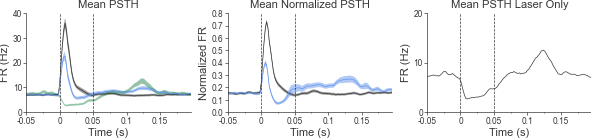

In [84]:
# Plot average PSTH for all cells.
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(6,3)

ax[0].plot(time, meanLaserOff_masked.mean(axis=1),c=_new_black)
ax[0].plot(time, meanLaserOn_masked.mean(axis=1),'CornflowerBlue')
ax[0].axvline(x=tStart,ls='--', c=_new_black)
ax[0].axvline(x=tDur,ls='--', c=_new_black)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('FR (Hz)')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].fill_between(time, meanLaserOff_masked.mean(axis=1)-errorOff, meanLaserOff_masked.mean(axis=1)+errorOff,\
                  alpha=0.5, facecolor= _new_black)
ax[0].fill_between(time, meanLaserOn_masked.mean(axis=1)-errorOn, meanLaserOn_masked.mean(axis=1)+errorOn,\
                  alpha=0.5, facecolor='CornflowerBlue') 

ax[0].fill_between(time, toneRespPSTH_Laser.mean(axis=0).mean(axis=1)-errorLaserOnly, toneRespPSTH_Laser.mean(axis=0).mean(axis=1)+errorLaserOnly,\
                  alpha=0.5, facecolor='seagreen') 

ax[0].set_yticks(np.ceil(ax[0].get_yticks()/10) * 10)
ymin0, ymax0 = ax[0].get_ylim()
ax[0].set_ylim(0, ymax0)
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(10))
ax[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[0].set_xlim(np.min(time), np.max(time))
ax[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(2))
ax[0].tick_params(which='major', color=_new_black)
ax[0].tick_params(which='minor', color=_new_black)



ax[1].plot(time, norm_PSTH_OFF_masked.mean(axis=1),c=_new_black)
ax[1].plot(time, norm_PSTH_On_masked.mean(axis=1),'CornflowerBlue')
ax[1].axvline(x=tStart,ls='--',c=_new_black)
ax[1].axvline(x=tDur,ls='--', c=_new_black)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Normalized FR')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

ax[1].fill_between(time, norm_PSTH_OFF_masked.mean(axis=1)-errorOff_n, norm_PSTH_OFF_masked.mean(axis=1)+errorOff_n,\
                  alpha=0.5, facecolor=_new_black)
ax[1].fill_between(time, norm_PSTH_On_masked.mean(axis=1)-errorOn_n, norm_PSTH_On_masked.mean(axis=1)+errorOn_n,\
                  alpha=0.5, facecolor='CornflowerBlue')
ax[1].set_yticks(np.round(ax[1].get_yticks(),1))
ymin1, ymax1 = ax[1].get_ylim()
ax[1].set_ylim(0, ymax1)
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax[1].set_xlim(np.min(time), np.max(time))
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(2))
ax[1].tick_params(which='major', color=_new_black)
ax[1].tick_params(which='minor', color=_new_black)



ax[2].plot(time, toneRespPSTH_Laser.mean(axis=0).mean(axis=1),c=_new_black)
ax[2].axvline(x=laserStart,ls='--', c=_new_black)
ax[2].axvline(x=laserOnlyDur,ls='--', c=_new_black)
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('FR (Hz)')
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].set_yticks(np.ceil(ax[2].get_yticks()/10) * 10)
ymin2, ymax2 = ax[2].get_ylim()
ax[2].set_ylim(0, ymax2)
ax[2].yaxis.set_major_locator(ticker.MultipleLocator(10))
ax[2].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[2].set_xlim(np.min(time), np.max(time))
ax[2].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
ax[2].xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax[2].xaxis.set_minor_locator(AutoMinorLocator(2))
ax[2].tick_params(which='major', color=_new_black)
ax[2].tick_params(which='minor', color=_new_black)



ax[0].set_box_aspect(.6)
ax[1].set_box_aspect(.6)
ax[2].set_box_aspect(.6)


ax[0].spines['left'].set_bounds((0, ymax0))
ax[1].spines['left'].set_bounds((0, ymax1))
ax[2].spines['left'].set_bounds((0, ymax2))

ax[0].set_title('Mean PSTH')
ax[1].set_title('Mean Normalized PSTH')
ax[2].set_title('Mean PSTH Laser Only')


fig.align_ylabels(ax[:])
fig.align_xlabels(ax[:])

plot_name = "Mean_PSTH_AllCells_%s.pdf"%cellType
fig.savefig(os.path.join(fig_dir_time,plot_name))

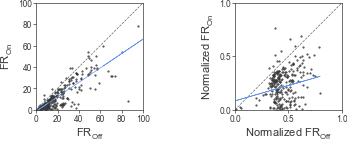

In [85]:
# Plot scatter plots of firing rates during tone presentation in laserOff and laserOn conditions.
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(4, 1.5)

# First subplot
ax[0].scatter(meanLaserOff_masked[early_evoked_Ind, :].mean(axis=0), 
              meanLaserOn_masked[early_evoked_Ind, :].mean(axis=0), 
              s=0.25, c=_new_black, facecolor=_new_black)
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, color='dimgrey', ls="--")
ax[0].set_xlabel('FR$_{Off}$')
ax[0].set_ylabel('FR$_{On}$')

# Adding a best fit line to the first subplot
m, b = np.polyfit(meanLaserOff_masked[early_evoked_Ind, :].mean(axis=0), 
                  meanLaserOn_masked[early_evoked_Ind, :].mean(axis=0), 1)
ax[0].plot(meanLaserOff_masked[early_evoked_Ind, :].mean(axis=0), m * meanLaserOff_masked[early_evoked_Ind, :].mean(axis=0) + b, 'CornflowerBlue')

# Setting ticks and limits for the first subplot
ax[0].set_ylim(0, 100)
ax[0].set_xlim(0, 100)
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(20))
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(20))
ax[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

# Second subplot
ax[1].scatter(norm_PSTH_OFF_masked[early_evoked_Ind, :].mean(axis=0), 
              norm_PSTH_On_masked[early_evoked_Ind, :].mean(axis=0), 
              s=0.25, c=_new_black, facecolor=_new_black)
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes, color='dimgrey', ls="--")
ax[1].set_xlabel('Normalized FR$_{Off}$')
ax[1].set_ylabel('Normalized FR$_{On}$')

# Adding a best fit line to the second subplot
m_norm, b_norm = np.polyfit(norm_PSTH_OFF_masked[early_evoked_Ind, :].mean(axis=0), 
                            norm_PSTH_On_masked[early_evoked_Ind, :].mean(axis=0), 1)
ax[1].plot(norm_PSTH_OFF_masked[early_evoked_Ind, :].mean(axis=0), m_norm * norm_PSTH_OFF_masked[early_evoked_Ind, :].mean(axis=0) + b_norm, 'CornflowerBlue')

# Setting ticks and limits for the second subplot
ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 1)
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Ensuring equal aspect ratio for both subplots
ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)

# Aligning labels
fig.align_ylabels(ax[:])
fig.align_xlabels(ax[:])

plt.show()

plot_name = f"ScatterPlots_Evoked_{cellType}.pdf"
fig.savefig(os.path.join(fig_dir_time, plot_name), bbox_inches='tight', dpi=600, transparent=True)

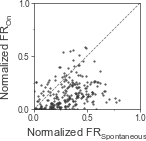

In [87]:
# Plot scatter plots of firing rates during laser presentation and spontaneous activity.
fig, ax = plt.subplots()
fig.set_size_inches(2, 1.5)

# Scatter plot with customized settings
ax.scatter(PSTH_Laser_norm_masked[spontInd, :].mean(axis=0), 
           PSTH_Laser_norm_masked[early_evoked_Ind, :].mean(axis=0), 
           s=0.25, c=_new_black, facecolor=_new_black, rasterized=True)

# Diagonal line indicating y=x for reference
ax.plot([0, 1], [0, 1], color='dimgrey', ls="--")

# Set labels
ax.set_xlabel('Normalized FR$_{Spontaneous}$')
ax.set_ylabel('Normalized FR$_{On}$')

# Directly set limits and major tick formatting
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Minor tick adjustments
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='major', color=_new_black)
ax.tick_params(which='minor', color=_new_black)

# Ensure square aspect ratio
ax.set_box_aspect(1)

# Save the figure
plot_name = f"ScatterPlot_LaserOnly_{cellType}.pdf"
fig.savefig(os.path.join(fig_dir_time, plot_name), bbox_inches='tight', dpi=600, transparent=True)

plt.show()

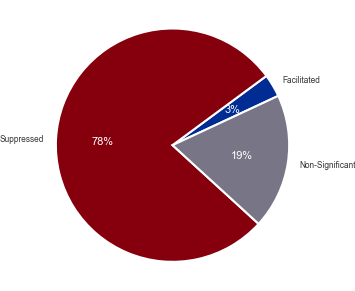

In [89]:
# Plot pie chart for facilitated and suppressed cells:
pie_data = [len(facilitated_Ind), len(suppressed_Ind), len(toneIndex)]
pie_data

fig, ax = plt.subplots()
fig.set_size_inches(4,3)
labels = 'Facilitated', 'Suppressed', 'Non-Significant'
colors = ['#002c94','#85000c','#787586']
patches, texts, pcts =ax.pie(pie_data,labels=labels, wedgeprops={'linewidth':1.5, 'edgecolor':'white'}, startangle = 25,\
         colors = colors,autopct='%.0f%%')
plt.setp(pcts, color='white')

plot_name = "PieChart_%s.pdf"%cellType

fig.savefig(os.path.join(fig_dir_time,"PieChart.pdf"), bbox_inches='tight', dpi=600, transparent = True)

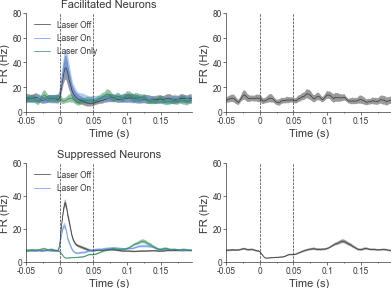

In [92]:
# Plot mean PSTH for the separated groups during tone-presentation & laser only:

fig = plt.figure()
gs = fig.add_gridspec(2, 2)
fig.set_size_inches(4,3)

ax0 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax0, sharex=ax0)

ax1 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1], sharey=ax1, sharex=ax1)


ax0.plot(time,facilitated_cells_Off.mean(axis = 1),c=_new_black)
ax0.plot(time, facilitated_cells_On.mean(axis = 1),'CornflowerBlue')
ax0.plot(time, toneRespPSTH_Laser.mean(axis=0)[:,facilitated_Ind].mean(axis=1),c='seagreen')
ax0.axvline(x=tStart,ls='--', c=_new_black)
ax0.axvline(x=tDur,ls='--', c=_new_black)
ax0.legend(['Laser Off','Laser On','Laser Only'])
ax0.set_title('Facilitated Neurons')
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('FR (Hz)')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.fill_between(time, facilitated_cells_Off.mean(axis=1)-errorOff_facil, \
                   facilitated_cells_Off.mean(axis=1)+errorOff_facil,\
                  alpha=0.5, facecolor=_new_black)
ax0.fill_between(time, facilitated_cells_On.mean(axis=1)-errorOn_facil, \
                   facilitated_cells_On.mean(axis=1)+errorOn_facil,\
                  alpha=0.5, facecolor='CornflowerBlue')
ax0.fill_between(time, toneRespPSTH_Laser.mean(axis=0)[:,facilitated_Ind].mean(axis=1)-errorlasfacil, \
                   toneRespPSTH_Laser.mean(axis=0)[:,facilitated_Ind].mean(axis=1)+errorlasfacil,\
                  alpha=0.5, facecolor='seagreen') 
ax0.set_yticks(np.floor(ax0.get_yticks()/20) * 20)
ymin0, ymax0 = ax0.get_ylim()
ax0.set_ylim(0, ymax0)
ax0.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax0.set_xlim(np.min(time), np.max(time))
ax0.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax0.xaxis.set_minor_locator(AutoMinorLocator(2))
ax0.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
ax0.tick_params(which='major', color=_new_black)
ax0.tick_params(which='minor', color=_new_black)



ax1.plot(time,suppressed_cells_Off.mean(axis = 1),c=_new_black)
ax1.plot(time, suppressed_cells_On.mean(axis = 1),'CornflowerBlue')
ax1.plot(time, toneRespPSTH_Laser.mean(axis=0)[:,suppressed_Ind].mean(axis=1),c='seagreen')
ax1.axvline(x=tStart,ls='--', c=_new_black)
ax1.axvline(x=tDur,ls='--', c=_new_black)
ax1.legend(['Laser Off','Laser On'])
ax1.set_title('Suppressed Neurons')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('FR (Hz)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.fill_between(time, suppressed_cells_Off.mean(axis=1)-errorOff_supp, \
                   suppressed_cells_Off.mean(axis=1)+errorOff_supp,\
                  alpha=0.5, facecolor=_new_black)
ax1.fill_between(time, suppressed_cells_On.mean(axis=1)-errorOn_supp, \
                   suppressed_cells_On.mean(axis=1)+errorOn_supp,\
                  alpha=0.5, facecolor='CornflowerBlue')
ax1.fill_between(time, toneRespPSTH_Laser.mean(axis=0)[:,suppressed_Ind].mean(axis=1)-errorlassupp, \
                   toneRespPSTH_Laser.mean(axis=0)[:,suppressed_Ind].mean(axis=1)+errorlassupp,\
                  alpha=0.5, facecolor='seagreen') 
ax1.set_yticks(np.floor(ax1.get_yticks()/20) * 20)
ymin1, ymax1 = ax1.get_ylim()
ax1.set_ylim(0, ymax1)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax1.set_xlim(np.min(time), np.max(time))
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.tick_params(which='major', color=_new_black)
ax1.tick_params(which='minor', color=_new_black)



ax2.plot(time, toneRespPSTH_Laser.mean(axis=0)[:,facilitated_Ind].mean(axis=1),c=_new_black)
ax2.fill_between(time, toneRespPSTH_Laser.mean(axis=0)[:,facilitated_Ind].mean(axis=1)-errorlasfacil, \
                   toneRespPSTH_Laser.mean(axis=0)[:,facilitated_Ind].mean(axis=1)+errorlasfacil,\
                  alpha=0.5, facecolor=_new_black)
ax2.axvline(x=laserStart,ls='--', c=_new_black)
ax2.axvline(x=laserOnlyDur,ls='--', c=_new_black)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('FR (Hz)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_yticks(np.ceil(ax2.get_yticks()/20) * 20)
ymin2, ymax2 = ax2.get_ylim()
ax2.set_ylim(0, ymax2)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax2.set_xlim(np.min(time), np.max(time))
ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(which='major', color=_new_black)
ax2.tick_params(which='minor', color=_new_black)




ax3.plot(time, toneRespPSTH_Laser.mean(axis=0)[:,suppressed_Ind].mean(axis=1),c=_new_black)
ax3.fill_between(time, toneRespPSTH_Laser.mean(axis=0)[:,suppressed_Ind].mean(axis=1)-errorlassupp, \
                   toneRespPSTH_Laser.mean(axis=0)[:,suppressed_Ind].mean(axis=1)+errorlassupp,\
                  alpha=0.5, facecolor=_new_black)
ax3.axvline(x=laserStart,ls='--', c=_new_black)
ax3.axvline(x=laserOnlyDur,ls='--', c=_new_black)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('FR (Hz)')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_yticks(np.ceil(ax3.get_yticks()/20) * 20)
ymin3, ymax3 = ax3.get_ylim()
ax3.set_ylim(0, ymax3)
ax3.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax3.set_xlim(np.min(time), np.max(time))
ax3.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax3.xaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(which='major', color=_new_black)
ax3.tick_params(which='minor', color=_new_black)



ax0.set_box_aspect(.6)
ax1.set_box_aspect(.6)
ax2.set_box_aspect(.6)
ax3.set_box_aspect(.6)


fig.align_ylabels([ax0,ax1,ax2,ax3])
fig.align_xlabels([ax0,ax1,ax2,ax3])

plot_name = "MeanPSTH_Divided_%s.pdf"%cellType
fig.savefig(os.path.join(fig_dir_time,plot_name))

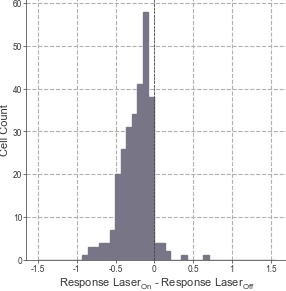

In [93]:
# Histogram demonstrating the difference in firing rates:

fig, ax = plt.subplots(figsize=(4, 3))

# Clip values and calculate bins directly within the hist function for brevity
bins = np.arange(-1.5, 1.5 + 0.071, 0.071)
ax.hist(np.clip(diff_resp_norm_EarlyOn_array, -1.5, 1.5), bins=bins, color="#787586", edgecolor="#787586")

# Simplifying axvline and labels in a compact way
ax.axvline(x=0, color=_new_black, linestyle='--')
ax.set(xlabel=r'Response Laser$_{On}$ - Response Laser$_{Off}$', ylabel='Cell Count', axisbelow=True)

# Minor grid, tick, and aspect adjustments can be made more concise
ax.grid(linestyle='--', which='both')
ax.tick_params(which='major', color=_new_black)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
ax.set_box_aspect(1)


plot_name = f"Histogram_Diff_{cellType}.pdf"
fig.savefig(os.path.join(fig_dir_time, plot_name))

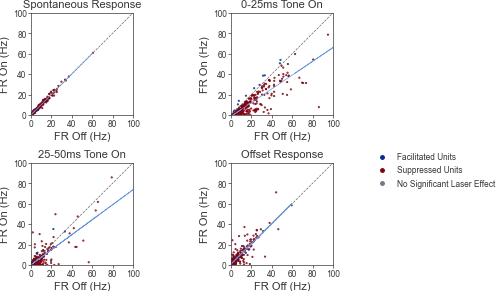

In [95]:
# Plot scatter plot with differentiated groups with normalized firing rates:
colors_ind = ['#002c94' if diff > 0 else '#85000c' if diff < 0 else '#787586' for diff in diff_resp_norm_EarlyOn_array]

# Plot scatter plot with differentiated groups for all the time points:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(4,3)
ax[0,0].scatter(meanLaserOff_masked[spontInd,:].mean(axis=0), \
           meanLaserOn_masked[spontInd,:].mean(axis=0), s=.25, color=colors_ind)
ax[0,0].plot([0,1],[0,1], transform=ax[0,0].transAxes, color='dimgrey', ls = "--")
ax[0,0].set_title('Spontaneous Response')
ax[0,0].set_xlabel('FR Off (Hz)')
ax[0,0].set_ylabel('FR On (Hz)')


ax[0,1].scatter(meanLaserOff_masked[early_evoked_Ind,:].mean(axis=0), \
           meanLaserOn_masked[early_evoked_Ind,:].mean(axis=0), s=.25, color=colors_ind)
ax[0,1].plot([0,1],[0,1], transform=ax[0,1].transAxes, color='dimgrey', ls = "--")
ax[0,1].set_title('0-25ms Tone On')
ax[0,1].set_xlabel('FR Off (Hz)')
ax[0,1].set_ylabel('FR On (Hz)')


ax[1,0].scatter(meanLaserOff_masked[late_evoked_Ind,:].mean(axis=0), \
           meanLaserOn_masked[late_evoked_Ind,:].mean(axis=0), s=.25, color=colors_ind)
ax[1,0].plot([0,1],[0,1], transform=ax[1,0].transAxes, color='dimgrey', ls = "--")
ax[1,0].set_title('25-50ms Tone On')
ax[1,0].set_xlabel('FR Off (Hz)', loc = 'center')
ax[1,0].set_ylabel('FR On (Hz)', loc = 'center')


ax[1,1].scatter(meanLaserOff_masked[offsetInd,:].mean(axis=0), \
           meanLaserOn_masked[offsetInd,:].mean(axis=0), s=.25, color=colors_ind)
ax[1,1].plot([0,1],[0,1], transform=ax[1,1].transAxes, color='dimgrey', ls = "--")
ax[1,1].set_title('Offset Response')
ax[1,1].set_xlabel('FR Off (Hz)')
ax[1,1].set_ylabel('FR On (Hz)')


m_Scat, b_Scat = np.polyfit(meanLaserOff_masked[early_evoked_Ind,:].mean(axis=0)\
                            ,meanLaserOn_masked[early_evoked_Ind,:].mean(axis=0),1)

ax[0,1].plot(meanLaserOff_masked[early_evoked_Ind,:].mean(axis=0),  m_Scat*meanLaserOff_masked[early_evoked_Ind,:].mean(axis=0)\
           +  b_Scat, 'CornflowerBlue')

m_Scat1, b_Scat1 = np.polyfit(meanLaserOff_masked[late_evoked_Ind,:].mean(axis=0)\
                            ,meanLaserOn_masked[late_evoked_Ind,:].mean(axis=0),1)

ax[1,0].plot(meanLaserOff_masked[late_evoked_Ind,:].mean(axis=0),  m_Scat1*meanLaserOff_masked[late_evoked_Ind,:].mean(axis=0)\
           +  b_Scat1, 'CornflowerBlue')

m_Scat2, b_Scat2 = np.polyfit(meanLaserOff_masked[offsetInd,:].mean(axis=0)\
                            ,meanLaserOn_masked[offsetInd,:].mean(axis=0),1)

ax[1,1].plot(meanLaserOff_masked[offsetInd,:].mean(axis=0),  m_Scat2*meanLaserOff_masked[offsetInd,:].mean(axis=0)\
           +  b_Scat2, 'CornflowerBlue')

m_Scat3, b_Scat3 = np.polyfit(meanLaserOff_masked[spontInd,:].mean(axis=0)\
                            ,meanLaserOn_masked[spontInd,:].mean(axis=0),1)

ax[0,0].plot(meanLaserOff_masked[spontInd,:].mean(axis=0),  m_Scat3*meanLaserOff_masked[spontInd,:].mean(axis=0)\
           +  b_Scat3, 'CornflowerBlue')




ax[0,0].set_yticks(np.ceil(ax[0,0].get_yticks()/10) * 10)
ymin0, ymax0 = ax[0,0].get_ylim()
ax[0,0].set_ylim(0, 100)
ax[0,0].yaxis.set_major_locator(ticker.MultipleLocator(20))
ax[0,0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[0,0].set_xticks(np.ceil(ax[0,0].get_xticks()/10) * 10)
xmin0, xmax0 = ax[0,0].get_xlim()
ax[0,0].set_xlim(0, 100)
ax[0,0].xaxis.set_major_locator(ticker.MultipleLocator(20))
ax[0,0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[0,0].tick_params(which='major', color=_new_black)
ax[0,0].tick_params(which='minor', color=_new_black)



ax[0,1].set_yticks(np.ceil(ax[0,1].get_yticks()/10) * 10)
ymin1, ymax1 = ax[0,1].get_ylim()
ax[0,1].set_ylim(0, 100)
ax[0,1].yaxis.set_major_locator(ticker.MultipleLocator(20))
ax[0,1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[0,1].set_xticks(np.ceil(ax[0,1].get_xticks()/10) * 10)
xmin1, xmax1 = ax[0,1].get_xlim()
ax[0,1].set_xlim(0, 100)
ax[0,1].xaxis.set_major_locator(ticker.MultipleLocator(20))
ax[0,1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[0,1].tick_params(which='major', color=_new_black)
ax[0,1].tick_params(which='minor', color=_new_black)




ax[1,0].set_yticks(np.ceil(ax[1,0].get_yticks()/10) * 10)
ymin2, ymax2 = ax[1,0].get_ylim()
ax[1,0].set_ylim(0, 100)
ax[1,0].yaxis.set_major_locator(ticker.MultipleLocator(20))
ax[1,0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[1,0].set_xticks(np.ceil(ax[1,0].get_xticks()/10) * 10)
xmin2, xmax2 = ax[1,0].get_xlim()
ax[1,0].set_xlim(0, 100)
ax[1,0].xaxis.set_major_locator(ticker.MultipleLocator(20))
ax[1,0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[1,0].tick_params(which='major', color=_new_black)
ax[1,0].tick_params(which='minor', color=_new_black)




ax[1,1].set_yticks(np.ceil(ax[1,1].get_yticks()/10) * 10)
ymin3, ymax3 = ax[1,1].get_ylim()
ax[1,1].set_ylim(0, 100)
ax[1,1].yaxis.set_major_locator(ticker.MultipleLocator(20))
ax[1,1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

ax[1,1].set_xticks(np.ceil(ax[1,1].get_xticks()/10) * 10)
xmin3, xmax3 = ax[1,1].get_xlim()
ax[1,1].set_xlim(0, 100)
ax[1,1].xaxis.set_major_locator(ticker.MultipleLocator(20))
ax[1,1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))




ax[1,1].tick_params(which='major', color=_new_black)
ax[1,1].tick_params(which='minor', color=_new_black)
ax[0,0].spines['left'].set_bounds((0, 100))
ax[0,1].spines['left'].set_bounds((0, 100))
ax[1,0].spines['left'].set_bounds((0, 100))
ax[1,1].spines['left'].set_bounds((0, 100))



ax[0,0].set_box_aspect(1)
ax[0,1].set_box_aspect(1)
ax[1,0].set_box_aspect(1)
ax[1,1].set_box_aspect(1)

fig.align_ylabels(ax[:])
fig.align_xlabels(ax[:])



legend_elements = [Line2D([0], [0], marker='.',color='#002c94', label='Facilitated Units', markerfacecolor='#002c94', markersize=5, linestyle = 'None'),\
                   Line2D([0], [0], marker='.', color='#85000c', label='Suppressed Units',markerfacecolor='#85000c', markersize=5,linestyle = 'None'),\
                   Line2D([0], [0], marker='.', color='#787586', label='No Significant Laser Effect', markerfacecolor='#787586', markersize=5,linestyle = 'None')]

# Adjust the legend placement
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1,0.5), frameon=False)

plt.show()


plot_name = "ScatterPlots_AllTimes_RawFR%s.pdf"%cellType
fig.savefig(os.path.join(fig_dir_time,plot_name))

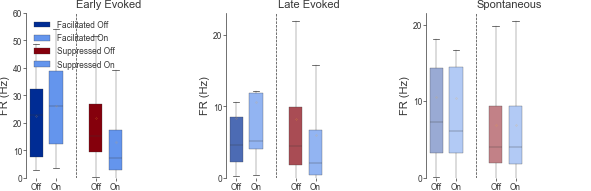

In [97]:
# Plot bar plots showing Firing rates during laser off and laser on trials during the spontaneous, evoked and late-evoked time:

fig, axs = plt.subplots(1, 3, figsize=(6, 2))  # Adjusting figsize for horizontal layout

# Common properties and customizations
boxprops = dict(linewidth=.2, color=_new_black)
capprops = dict(linestyle='-', linewidth=0.5)
medianprops = dict(linestyle='-', color=_new_black, linewidth=0.25)
whiskerprops = dict(linestyle='-', color=_new_black, linewidth=0.25)
meanpointprops = dict(marker='.', markeredgecolor='#f7ab31', markerfacecolor='#f7ab31', linewidth=0.25, markersize=.25)
colors = [['#002c94', 'CornflowerBlue', '#85000c', 'CornflowerBlue'],
          ['#4C6BB4', '#92B4F2', '#A94C54', '#92B4F2'],
          ['#99AAD4', '#B2CAF5', '#C28187', '#B2CAF5']]
titles = ['Early Evoked', 'Late Evoked', 'Spontaneous']

for i, ax in enumerate(axs):
    # Selecting the correct dataset for each subplot
    if i == 0:
        data_indices = early_evoked_Ind
    elif i == 1:
        data_indices = late_evoked_Ind
    else:  # i == 2
        data_indices = spontInd

    data = [facilitated_cells_Off[data_indices, :].mean(axis=0), facilitated_cells_On[data_indices, :].mean(axis=0),
            suppressed_cells_Off[data_indices, :].mean(axis=0), suppressed_cells_On[data_indices, :].mean(axis=0)]

    # Creating the boxplot
    bplot = ax.boxplot(data, notch=False, showmeans=True, patch_artist=True, meanprops=meanpointprops,
                       meanline=False, medianprops=medianprops, positions=[0.15, .45, 1.05, 1.35],
                       widths=0.20, boxprops=boxprops, capprops=capprops, showfliers=False, whiskerprops=whiskerprops)

    ax.axvline(x=.75, color=_new_black, linestyle='--')
    for patch, color in zip(bplot['boxes'], colors[i]):
        patch.set_facecolor(color)

    ax.set_yticks(np.floor(ax.get_yticks() / 10) * 10)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(0, ymax)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.set_ylabel('FR (Hz)')
    ax.tick_params(which='major', color=_new_black)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_bounds((0, ymax))
    ax.set_xlim([0, 2.5])
    ax.set_xticklabels(['Off', 'On', 'Off', 'On'])
    ax.set_title(titles[i])

    if i == 0:  # Only add legend to the first plot (or choose according to preference)
        ax.legend([*bplot["boxes"]], ['Facilitated Off', 'Facilitated On', 'Suppressed Off', 'Suppressed On'], loc='upper left')

plt.show()

# Assuming cellType and fig_dir_time are defined
plot_name = "FR_BPlot_Combined_%s.pdf" % cellType
fig.savefig(os.path.join(fig_dir_time, plot_name))


[None, None]

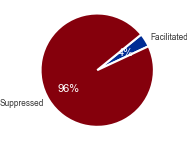

In [99]:
# Plot pie chart with total percentage of cells
pie_data_sort = [len(diff_Sorted_facil_norm), len(diff_Sorted_supp_norm)]

fig, ax = plt.subplots()
fig.set_size_inches(2,1.5)
labels = 'Facilitated', 'Suppressed'
colors = ['#002c94','#85000c','#787586']
patches, texts, pcts =ax.pie(pie_data_sort,labels=labels, wedgeprops={'linewidth':1.5, 'edgecolor':'white'}, startangle = 25,\
         colors = colors,autopct='%.0f%%')
plt.setp(pcts, color='white')

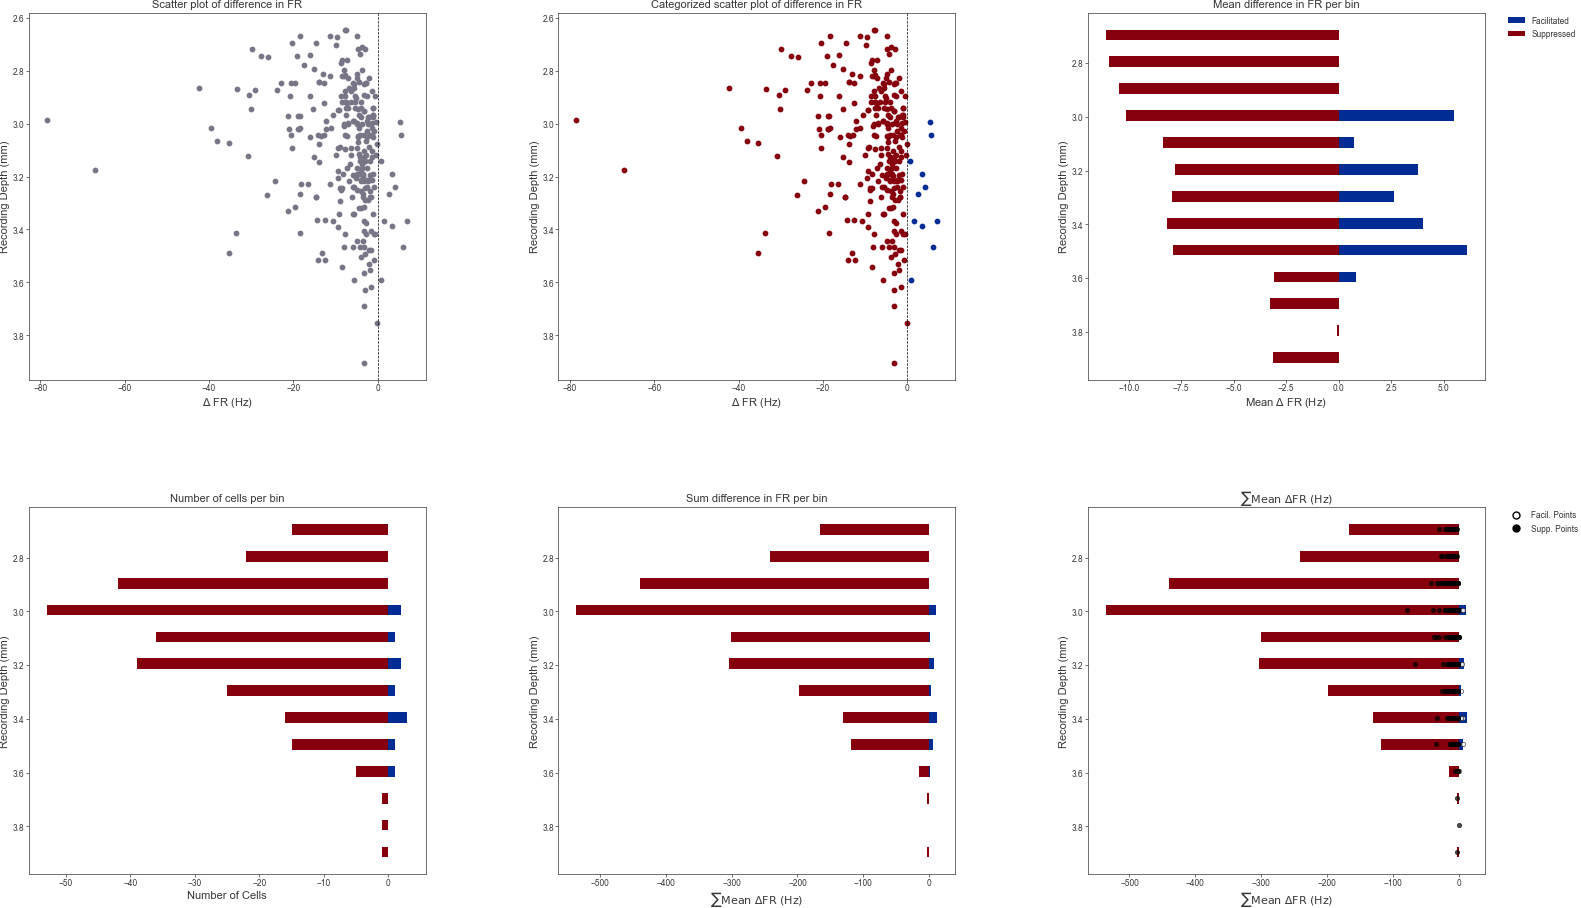

In [100]:
# Create a figure with 2 rows and 3 columns of subplots

fig, axs = plt.subplots(2, 3, figsize=(17, 11), constrained_layout=False)
fig.tight_layout(pad=10)


# Plot 1: scatter plot
ax = axs[0, 0]
ax.scatter(diff_resp_EarlyOn_array, depths_numeric, color='#787586', s=10)
ax.invert_yaxis()
# ax.set_ylim(-800, 25)
# ax.set_xlim(-1.05, 1.05)
ax.axvline(x=0, color='black', linestyle='--')
ax.set_xlabel(r'$\Delta$ FR (Hz)')
ax.set_ylabel('Recording Depth (mm)')
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.set_title('Scatter plot of difference in FR')

# Plot 2: Scatter plot with categories
ax = axs[0, 1]
ax.scatter(diff_Sorted_facil, depths_numeric_facil, color='#002c94', s=10, label='Facilitated')
ax.scatter(diff_Sorted_supp, depths_numeric_supp, color='#85000c', s=10, label='Suppressed')
ax.invert_yaxis()
# ax.set_ylim(-800, 25)
# ax.set_xlim(-1.05, 1.05)
ax.axvline(x=0, color='black', linestyle='--')
ax.set_xlabel(r'$\Delta$ FR (Hz)')
ax.set_ylabel('Recording Depth (mm)')
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.set_title('Categorized scatter plot of difference in FR')

# Plot 3: Bar plot (aggregated mean)
ax = axs[0, 2]
ax.barh(bin_centers, facil_agg, height=bin_size * 0.4, label='Facilitated', color='#002c94')
ax.barh(bin_centers, supp_agg, height=bin_size * 0.4, label='Suppressed', color='#85000c')
ax.set_xlabel(r'Mean $\Delta$ FR (Hz)')
ax.set_ylabel('Recording Depth (mm)')
ax.invert_yaxis()
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.set_title('Mean difference in FR per bin')


# Plot 4: Bar plot (counts)
ax = axs[1, 0]
ax.barh(bin_centers, facil_counts, height=bin_size * 0.4, label='Facilitated', color='#002c94')
ax.barh(bin_centers, -supp_counts, height=bin_size * 0.4, label='Suppressed', color='#85000c')
ax.set_xlabel('Number of Cells')
ax.set_ylabel('Recording Depth (mm)')
ax.invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.set_title('Number of cells per bin')

# Plot 5: Bar plot (sum)
ax = axs[1, 1]
ax.barh(bin_centers, facil_sum, height=bin_size * 0.4, label='Facilitated', color='#002c94')
ax.barh(bin_centers, supp_sum, height=bin_size * 0.4, label='Suppressed', color='#85000c')
ax.set_xlabel(r'$\sum \text{Mean } \Delta \text{FR (Hz)}$')
ax.set_ylabel('Recording Depth (mm)')
ax.invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.set_title('Sum difference in FR per bin')


# Plot 6: Scatter plot on top of bars for individual points
ax = axs[1, 2]
ax.barh(bin_centers, facil_sum, height=bin_size * 0.4, color='#002c94', label='Facilitated')
ax.barh(bin_centers, supp_sum, height=bin_size * 0.4, color='#85000c', label='Suppressed')


for i in range(len(bin_centers)):
    # Adjust index access by removing the '-1' since we already start at 0
    facil_points = diff_Sorted_facil_norm[bin_indices_facil == i + 1]
    supp_points = diff_Sorted_supp_norm[bin_indices_supp == i + 1]
    facil_positions = np.full(facil_points.shape, bin_centers[i])
    supp_positions = np.full(supp_points.shape, bin_centers[i])
    
    # Plot the points; adjust 'alpha' for transparency as needed
    ax.scatter(facil_points, facil_positions, color='white', edgecolor = 'black', alpha=0.7, label='Facil. Points' if i == 1 else "", s = 10, linewidths=0.5)
    ax.scatter(supp_points, supp_positions, color='black', edgecolor = 'black',  alpha=0.7, label='Supp. Points' if i == 1 else "", s = 10, linewidths=0.5)

ax.set_ylabel('Recording Depth (mm)')
ax.invert_yaxis()
ax.set_xlabel(r'$\sum \text{Mean } \Delta \text{FR (Hz)}$')
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.set_title(r'$\sum \text{Mean } \Delta \text{FR (Hz)}$')


custom_legends = [Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markeredgecolor='black', label='Facil. Points', markersize=5, linewidth=0),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markeredgecolor='black', label='Supp. Points', markersize=5, linewidth=0)]

ax.legend(handles=custom_legends, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

plt.show()

# Saving the figure
plot_name = "Diff_resp_depthofprobe_AllPlots_TEST%s.pdf" % cellType
fig.savefig(os.path.join(fig_dir_time, plot_name), bbox_inches='tight', dpi=600, transparent=True)


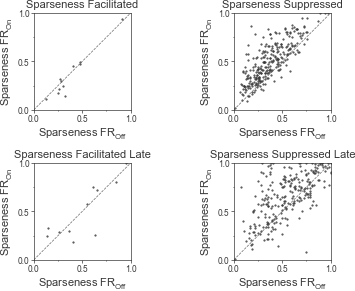

In [103]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(4,3)
ax[0,0].scatter(SparsenessOff_facilitated,SparsenessOn_facilitated, s=.25, c = _new_black)
ax[0,0].plot([0,1],[0,1], transform=ax[0,0].transAxes, color='dimgrey', ls = "--")
# ax.plot([-.35,1.85],[-.35,1.85], transform=ax.transAxes, color='dimgrey', ls = "--")
ax[0,0].set_title('Sparseness Facilitated')
ax[0,0].set_xlabel('Sparseness FR$_{Off}$')
ax[0,0].set_ylabel('Sparseness FR$_{On}$')
_, ymax = ax[0,0].get_ylim()
ax[0,0].set_ylim([0, 1])
ax[0,0].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax[0,0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
_, xmax = ax[0,0].get_xlim()
ax[0,0].set_xlim([0, 1])
ax[0,0].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax[0,0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax[0,0].yaxis.set_minor_locator(AutoMinorLocator(2))
ax[0,0].xaxis.set_minor_locator(AutoMinorLocator(2))
ax[0,0].tick_params(which='major', color=_new_black)
ax[0,0].tick_params(which='minor', color=_new_black)
ax[0,0].spines['left'].set_bounds((0, 1))
ax[0,0].spines['left'].set_bounds((0,1))
ax[0,0].set_box_aspect(1)


ax[0,1].scatter(SparsenessOff_suppressed,SparsenessOn_suppressed, s=.25, c = _new_black)
ax[0,1].plot([0,1],[0,1], transform=ax[0,1].transAxes, color='dimgrey', ls = "--")
# ax.plot([-.35,1.85],[-.35,1.85], transform=ax.transAxes, color='dimgrey', ls = "--")
ax[0,1].set_title('Sparseness Suppressed')
ax[0,1].set_xlabel('Sparseness FR$_{Off}$')
ax[0,1].set_ylabel('Sparseness FR$_{On}$')
_, ymax = ax[0,1].get_ylim()
ax[0,1].set_ylim([0, 1])
ax[0,1].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax[0,1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
_, xmax = ax[0,1].get_xlim()
ax[0,1].set_xlim([0, 1])
ax[0,1].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax[0,1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax[0,1].yaxis.set_minor_locator(AutoMinorLocator(2))
ax[0,1].xaxis.set_minor_locator(AutoMinorLocator(2))
ax[0,1].tick_params(which='major', color=_new_black)
ax[0,1].tick_params(which='minor', color=_new_black)
ax[0,1].spines['left'].set_bounds((0, 1))
ax[0,1].spines['left'].set_bounds((0,1))
ax[0,1].set_box_aspect(1)



ax[1,0].scatter(Late_SparsenessOff_facilitated, Late_SparsenessOn_facilitated, s=.25, c = _new_black)
ax[1,0].plot([0,1],[0,1], transform=ax[1,0].transAxes, color='dimgrey', ls = "--")
# ax.plot([-.35,1.85],[-.35,1.85], transform=ax.transAxes, color='dimgrey', ls = "--")
ax[1,0].set_title('Sparseness Facilitated Late')
ax[1,0].set_xlabel('Sparseness FR$_{Off}$')
ax[1,0].set_ylabel('Sparseness FR$_{On}$')
_, ymax = ax[1,0].get_ylim()
ax[1,0].set_ylim([0, 1])
ax[1,0].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax[1,0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
_, xmax = ax[1,0].get_xlim()
ax[1,0].set_xlim([0, 1])
ax[1,0].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax[1,0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax[1,0].yaxis.set_minor_locator(AutoMinorLocator(2))
ax[1,0].xaxis.set_minor_locator(AutoMinorLocator(2))
ax[1,0].tick_params(which='major', color=_new_black)
ax[1,0].tick_params(which='minor', color=_new_black)
ax[1,0].spines['left'].set_bounds((0, 1))
ax[1,0].spines['left'].set_bounds((0,1))
ax[1,0].set_box_aspect(1)


ax[1,1].scatter(Late_SparsenessOff_suppressed, Late_SparsenessOn_suppressed, s=.25, c =_new_black)
ax[1,1].plot([0,1],[0,1], transform=ax[1,1].transAxes, color='dimgrey', ls = "--")
# ax.plot([-.35,1.85],[-.35,1.85], transform=ax.transAxes, color='dimgrey', ls = "--")
ax[1,1].set_title('Sparseness Suppressed Late')
ax[1,1].set_xlabel('Sparseness FR$_{Off}$')
ax[1,1].set_ylabel('Sparseness FR$_{On}$')
_, ymax = ax[1,1].get_ylim()
ax[1,1].set_ylim([0, 1])
ax[1,1].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax[1,1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
_, xmax = ax[1,1].get_xlim()
ax[1,1].set_xlim([0, 1])
ax[1,1].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax[1,1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax[1,1].yaxis.set_minor_locator(AutoMinorLocator(2))
ax[1,1].xaxis.set_minor_locator(AutoMinorLocator(2))
ax[1,1].tick_params(which='major', color=_new_black)
ax[1,1].tick_params(which='minor', color=_new_black)
ax[1,1].spines['left'].set_bounds((0, 1))
ax[1,1].spines['left'].set_bounds((0,1))
ax[1,1].set_box_aspect(1)


plt.show()

plot_name = "Sparseness_AllTimePoints_%s.pdf"%cellType
fig.savefig(os.path.join(fig_dir_time,plot_name))

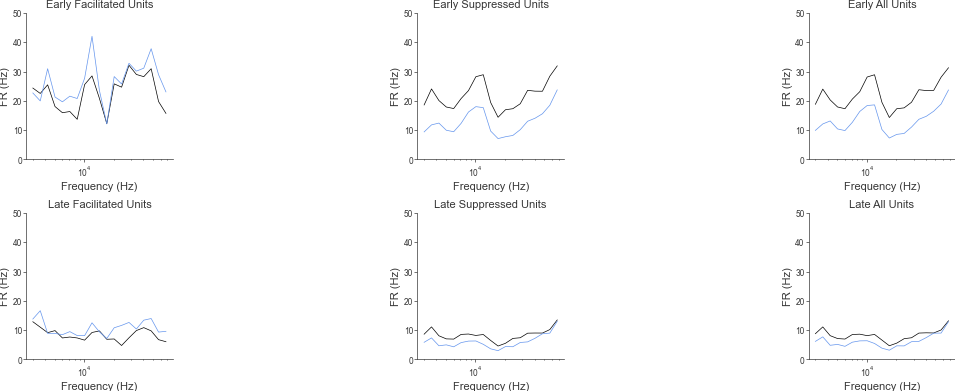

In [104]:
fig, ax = plt.subplots(2, 3)  # Create a 2x3 grid of subplots
fig.set_size_inches(12, 4)  # Adjust the overall figure size as needed

# First row plots
plot_data_TC(uniq_Freq, mTCOff_facil, mTCOn_facil, ax=ax[0, 0], title='Early Facilitated Units')
plot_data_TC(uniq_Freq, mTCOff_supp, mTCOn_supp, ax=ax[0, 1], title='Early Suppressed Units')
plot_data_TC(uniq_Freq, mTCOff, mTCOn, ax=ax[0, 2], title='Early All Units')

# Second row plots
plot_data_TC(uniq_Freq, Late_mTCOff_facil, Late_mTCOn_facil, ax=ax[1, 0], title='Late Facilitated Units')
plot_data_TC(uniq_Freq, Late_mTCOff_supp, Late_mTCOn_supp, ax=ax[1, 1], title='Late Suppressed Units')
plot_data_TC(uniq_Freq, Late_mTCOff, Late_mTCOn, ax=ax[1, 2], title='Late All Units')

# Assuming the calculation of global_ymin, global_ymax, and yticks as in your previous snippet
all_ys = np.hstack([a.get_ylim() for row in ax for a in row])  # Flatten the axes array to iterate
global_ymin, global_ymax = np.min(all_ys), np.max(all_ys)
tick_spacing = np.ceil((global_ymax - global_ymin) / 5 / 10) * 10
yticks = np.arange(np.floor(global_ymin / 10) * 10, np.ceil(global_ymax / 10) * 10 + tick_spacing, step=tick_spacing)

# Apply the calculated y-ticks to each subplot
for row in ax:
    for a in row:
        a.set_ylim(global_ymin, global_ymax)
        a.set_yticks(yticks)

fig.align_ylabels(ax[:, 0])  # Align y labels for the first column
fig.align_xlabels(ax[-1, :])  # Align x labels for the last row
plt.show()

# Saving the figure
plot_name = f"Mean_TCs_Divided_{cellType}.pdf"
fig.savefig(os.path.join(fig_dir_time, plot_name), bbox_inches='tight', dpi=600, transparent=True)


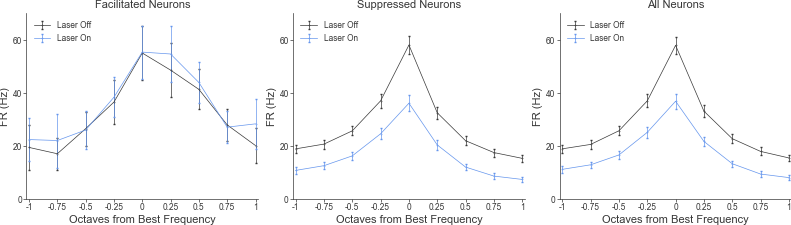

In [105]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(8,3)

ax[0].errorbar(octaves, np.nanmean(cFR_facil, axis=1), yerr = stats.sem(cFR_facil, axis=1, nan_policy='omit'),ecolor=_new_black, \
        linestyle='-', c=_new_black, mfc = _new_black, marker='o', markersize = .25,capsize=.5)

ax[0].errorbar(octaves, np.nanmean(cFR_On_facil, axis=1), yerr = stats.sem(cFR_On_facil, axis=1, nan_policy='omit'),\
            ecolor='CornflowerBlue', linestyle='-', c='CornflowerBlue', mfc = 'CornflowerBlue', marker='o', markersize = .25, capsize=.5)
ax[0].set_xlim(np.round(octaves[0]-0.025,3), np.round(octaves[-1]+0.025,3))
ax[0].set_xticks(np.round(octaves,2))
ax[0].set_title('Facilitated Neurons')
ax[0].set_ylabel('FR (Hz)')
ax[0].set_xlabel ('Octaves from Best Frequency')
ax[0].legend(['Laser Off','Laser On'])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_yticks(np.floor(ax[0].get_yticks()/10) * 10)
ymin0, ymax0 = ax[0].get_ylim()
ax[0].set_ylim(0, ymax0)
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(20))
ax[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))


ax[1].errorbar(octaves, np.nanmean(cFR_supp, axis=1), yerr = stats.sem(cFR_supp, axis=1, nan_policy='omit'),ecolor=_new_black, \
        linestyle='-', c=_new_black, mfc = _new_black, marker='o', markersize = .25, capsize=.5)

ax[1].errorbar(octaves, np.nanmean(cFR_On_supp, axis=1), yerr = stats.sem(cFR_On_supp, axis=1, nan_policy='omit'),\
            ecolor='CornflowerBlue', linestyle='-', c='CornflowerBlue', mfc = 'CornflowerBlue', marker='o', markersize = .25, capsize=.5)
ax[1].set_xlim(np.round(octaves[0]-0.025,3), np.round(octaves[-1]+0.025,3))
ax[1].set_xticks(np.round(octaves,2))
ax[1].set_title('Suppressed Neurons')
ax[1].set_ylabel('FR (Hz)')
ax[1].set_xlabel ('Octaves from Best Frequency')
ax[1].legend(['Laser Off','Laser On'])
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_yticks(np.floor(ax[1].get_yticks()/10) * 10)
ymin1, ymax1 = ax[1].get_ylim()
ax[1].set_ylim(0, ymax1)
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(20))
ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))


ax[2].errorbar(octaves, np.nanmean(cFR, axis=1), yerr = stats.sem(cFR, axis=1, nan_policy='omit'),ecolor=_new_black, \
        linestyle='-', c=_new_black, mfc = _new_black, marker='o', markersize = .25, capsize=.5)

ax[2].errorbar(octaves, np.nanmean(cFR_On, axis=1), yerr = stats.sem(cFR_On, axis=1, nan_policy='omit'),\
            ecolor='CornflowerBlue', linestyle='-', c='CornflowerBlue', mfc = 'CornflowerBlue', marker='o', markersize = .25, capsize=.5)
ax[2].set_xlim(np.round(octaves[0]-0.025,3), np.round(octaves[-1]+0.025,3))
ax[2].set_xticks(np.round(octaves,2))
ax[2].set_title('All Neurons')
ax[2].set_ylabel('FR (Hz)')
ax[2].set_xlabel ('Octaves from Best Frequency')
ax[2].legend(['Laser Off','Laser On'])
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].set_yticks(np.floor(ax[2].get_yticks()/10) * 10)
ymin2, ymax2 = ax[2].get_ylim()
ax[2].set_ylim(0, ymax1)
ax[2].yaxis.set_major_locator(ticker.MultipleLocator(20))
ax[2].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[2].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))

ax[0].tick_params(which='major', color=_new_black)
ax[0].tick_params(which='minor', color=_new_black)

ax[1].tick_params(which='major', color=_new_black)
ax[1].tick_params(which='minor', color=_new_black)

ax[2].tick_params(which='major', color=_new_black)
ax[2].tick_params(which='minor', color=_new_black)

ax[0].set_box_aspect(.8)
ax[1].set_box_aspect(.8)
ax[2].set_box_aspect(.8)

ax[0].spines['left'].set_bounds((0, ymax0))
ax[1].spines['left'].set_bounds((0, ymax1))
ax[2].spines['left'].set_bounds((0, ymax2))

fig.align_ylabels(ax[:])
fig.align_xlabels(ax[:])


plt.show()

plot_name = "Centered_TC_divded_%s.pdf"%cellType
# fig.savefig(os.path.join(fig_dir_time,plot_name))

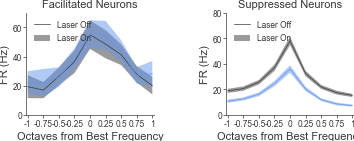

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(4, 1.5))


# Settings for both facilitated and suppressed neurons
settings = [
    (cFR_facil, cFR_On_facil, errorOff_tc_facil, errorOn_tc_facil, 'Facilitated Neurons', ax[0]),
    (cFR_supp, cFR_On_supp, errorOff_tc_supp, errorOn_tc_supp, 'Suppressed Neurons', ax[1])
]

for current_cFR, current_cFR_On, current_errorOff, current_errorOn, title, axis in settings:
    axis.plot(octaves, np.nanmean(current_cFR, axis=1), c=_new_black, linestyle='-')
    axis.fill_between(octaves, np.nanmean(current_cFR, axis=1) - current_errorOff, np.nanmean(current_cFR, axis=1) + current_errorOff, alpha=0.5, facecolor=_new_black)
    axis.plot(octaves, np.nanmean(current_cFR_On, axis=1), 'CornflowerBlue', linestyle='-')
    axis.fill_between(octaves, np.nanmean(current_cFR_On, axis=1) - current_errorOn, np.nanmean(current_cFR_On, axis=1) + current_errorOn, alpha=0.5, facecolor='CornflowerBlue')

    axis.set_xlim(np.round(octaves[0]-0.025,3), np.round(octaves[-1]+0.025,3))
    axis.set_xticks(np.round(octaves,2))
    axis.set_title(title)
    axis.set_ylabel('FR (Hz)')
    axis.set_xlabel('Octaves from Best Frequency')
    axis.legend(['Laser Off','Laser On'])
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.set_yticks(np.floor(axis.get_yticks()/10) * 10)
    ymin, ymax = axis.get_ylim()
    axis.set_ylim(0, ymax)
    axis.yaxis.set_major_locator(ticker.MultipleLocator(20))
    axis.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axis.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
    axis.tick_params(which='major', color=_new_black)
    axis.set_box_aspect(.8)
    axis.spines['left'].set_bounds((0, ymax))

fig.align_ylabels(ax[:])
fig.align_xlabels(ax[:])
plt.show()

plot_name = f"Centered_TC_divided_Patch_{cellType}.pdf"
fig.savefig(os.path.join(fig_dir_time,plot_name))

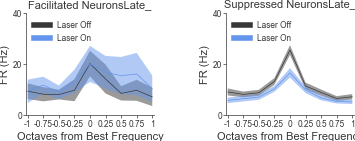

In [108]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(4, 1.5)

# Settings for both facilitated and suppressed neurons in the late time period
late_settings = [
    (Late_cFR_facil, Late_cFR_On_facil, Late_errorOff_tc_facil, Late_errorOn_tc_facil, 'Facilitated NeuronsLate_', ax[0]),
    (Late_cFR_supp, Late_cFR_On_supp, Late_errorOff_tc_supp, Late_errorOn_tc_supp, 'Suppressed NeuronsLate_', ax[1])
]

for Late_current_cFR, Late_current_cFR_On, Late_current_errorOff, Late_current_errorOn, title, axis in late_settings:
    axis.plot(octaves, np.nanmean(Late_current_cFR, axis=1), c=_new_black, linestyle='-')
    axis.fill_between(octaves, np.nanmean(Late_current_cFR, axis=1) - Late_current_errorOff, np.nanmean(Late_current_cFR, axis=1) + Late_current_errorOff, alpha=0.5, facecolor=_new_black)
    axis.plot(octaves, np.nanmean(Late_current_cFR_On, axis=1), 'CornflowerBlue', linestyle='-')
    axis.fill_between(octaves, np.nanmean(Late_current_cFR_On, axis=1) - Late_current_errorOn, np.nanmean(Late_current_cFR_On, axis=1) + Late_current_errorOn, alpha=0.5, facecolor='CornflowerBlue')
    axis.set_xlim(np.round(octaves[0]-0.025,3), np.round(octaves[-1]+0.025,3))
    axis.set_xticks(np.round(octaves,2))
    axis.set_title(title)
    axis.set_ylabel('FR (Hz)')
    axis.set_xlabel('Octaves from Best Frequency')
    axis.legend(['Laser Off','Laser On'])
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.set_yticks(np.floor(axis.get_yticks()/7) * 10)
    ymin, ymax = axis.get_ylim()
    axis.set_ylim(0, ymax)
    axis.yaxis.set_major_locator(ticker.MultipleLocator(20))
    axis.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axis.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
    axis.tick_params(which='major', color=_new_black)
    axis.set_box_aspect(.8)
    axis.spines['left'].set_bounds((0, ymax))

# Create custom legend handles
legend_elements = [Line2D([0], [0], color=_new_black, lw=4, label='Laser Off'),
                   Line2D([0], [0], color='CornflowerBlue', lw=4, label='Laser On'),
                   Patch(facecolor=_new_black, edgecolor=_new_black,
                         label='Laser Off Confidence', alpha=0.5),
                   Patch(facecolor='CornflowerBlue', edgecolor='CornflowerBlue',
                         label='Laser On Confidence', alpha=0.5)]

# Loop over axes to apply legend modifications
for axis in ax:
    axis.legend(handles=legend_elements[:2], loc='upper left')  # Adjust as needed
fig.align_ylabels(ax[:])
fig.align_xlabels(ax[:])
plt.show()


plot_name = f"Centered_TC_divided_Patch_LateTimePeriod{cellType}.pdf"
fig.savefig(os.path.join(fig_dir_time, plot_name))


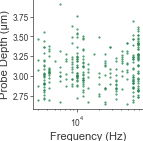

In [110]:
fig, ax = plt.subplots()
fig.set_size_inches(2,1.5)
ax.scatter(BF, depths_numeric, c='seagreen',s=.25)
ax.set_box_aspect(1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Probe Depth (µm)')
ax.set_xscale('log')
ax.tick_params(which='major',color=_new_black)
ax.tick_params(which='minor', color=_new_black)
plt.show()

plot_name = "BF_ProbeDepth_%s.pdf"%cellType
fig.savefig(os.path.join(fig_dir_time,plot_name))

# fig.savefig(os.path.join(fig_dir_time,"BF_ProbeDepth.pdf"), bbox_inches='tight', dpi=600, transparent = True)

/Users/solymarrolon/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/solymarrolon/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/solymarrolon/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/solymarrolon/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

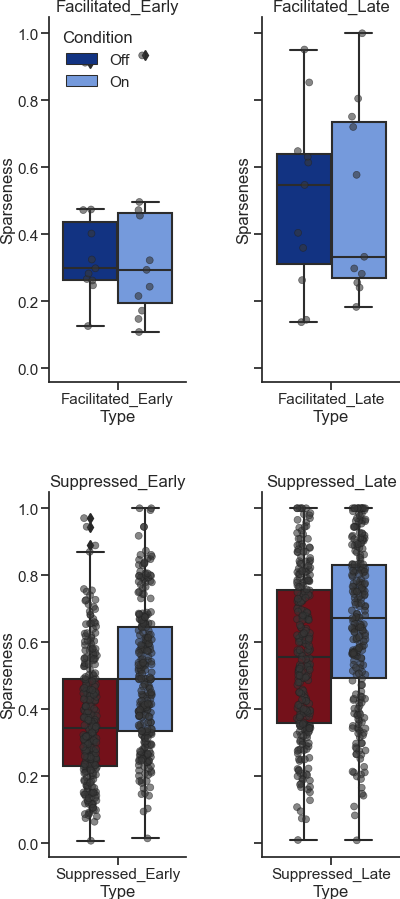

In [112]:
from sklearn import linear_model
from sklearn.impute import SimpleImputer
# from statannotations.Annotator import Annotator

data_frames = {
    'All': [SparsenessOff_all, SparsenessOn_all],
    'Facilitated_Early': [SparsenessOff_facilitated, SparsenessOn_facilitated],
    'Suppressed_Early': [SparsenessOff_suppressed, SparsenessOn_suppressed],
    'Facilitated_Late': [Late_SparsenessOff_facilitated, Late_SparsenessOn_facilitated],
    'Suppressed_Late': [Late_SparsenessOff_suppressed, Late_SparsenessOn_suppressed],

}

# Create a combined DataFrame
df_test = pd.concat([
    pd.DataFrame({
        'Sparseness': df,
        'Condition': 'Off' if i % 2 == 0 else 'On',
        'Type': key
    }) for key, dfs in data_frames.items() for i, df in enumerate(dfs)
], ignore_index=True)

# Define custom parameters to remove top and right spines
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


# Define the colors for boxplots
colors_facilitated = ['#002c94', 'CornflowerBlue']  # Off, On for facilitated
colors_suppressed = ['#85000c', 'CornflowerBlue']  # Off, On for suppressed

# Define the categories and their corresponding color maps for boxplots
categories = ['Facilitated_Early', 'Facilitated_Late', 'Suppressed_Early', 'Suppressed_Late']
color_maps = {
    'Facilitated_Early': colors_facilitated,
    'Facilitated_Late': colors_facilitated,
    'Suppressed_Early': colors_suppressed,
    'Suppressed_Late': colors_suppressed
}

# Prepare the plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 10), sharey=True)  # Adjusted figsize
axes = axes.flatten()

# Loop through each category to plot
for idx, category in enumerate(categories):
    ax = axes[idx]
    subset = df_test[df_test['Type'] == category]
    
    # Boxplot
    sns.boxplot(data=subset, x='Type', y='Sparseness', hue='Condition',
                palette=color_maps[category], ax=ax, zorder=1)
    
    # Stripplot with 'dimgrey' color using palette
    sns.stripplot(data=subset, x='Type', y='Sparseness', hue='Condition', dodge=True,
                  palette=[_new_black, _new_black], ax=ax, alpha=0.60, jitter=True, edgecolor='gray', linewidth=0.5, zorder=2)

    # Customize legend
    handles, labels = ax.get_legend_handles_labels()
    if idx == 0:
        ax.legend(handles[:2], ['Off', 'On'], title='Condition')
    else:
        ax.legend([], [], frameon=False)

    # Set title
    ax.set_title(category)

# Adjust labels and layout
plt.tight_layout(pad=3.0)  # Adjusted padding for layout
plt.show()

plot_name = f"Sparseness_divided_{cellType}.pdf"
fig.savefig(os.path.join(fig_dir_time,plot_name))

/Users/solymarrolon/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/solymarrolon/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/solymarrolon/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/solymarrolon/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

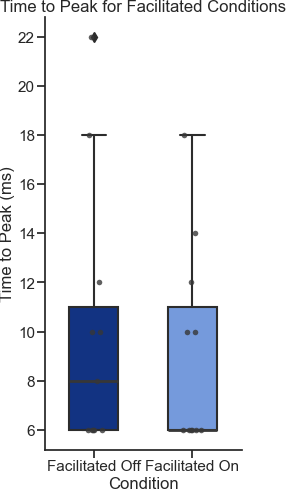

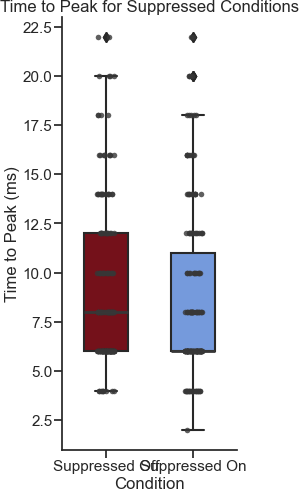

In [116]:
# Use the function for each condition
t2pOff, t2pOn = find_time_to_peak(peakCellstuseOff, peakCellstuseOn, early_evoked_Ind, spontInd)
t2pOff_facil, t2pOn_facil = find_time_to_peak(peakCellstuseOff_facil, peakCellstuseOn_facil, early_evoked_Ind, spontInd)
t2pOff_supp, t2pOn_supp = find_time_to_peak(peakCellstuseOff_supp, peakCellstuseOn_supp, early_evoked_Ind, spontInd)


# Creating separate dataframes and adding a new 'Condition' column
df_facil_off = pd.DataFrame({'Time': [time * 1000 for time in t2pOff_facil], 'Condition': 'Facilitated Off'})
df_facil_on = pd.DataFrame({'Time': [time * 1000 for time in t2pOn_facil], 'Condition': 'Facilitated On'})
df_supp_off = pd.DataFrame({'Time': [time * 1000 for time in t2pOff_supp], 'Condition': 'Suppressed Off'})
df_supp_on = pd.DataFrame({'Time': [time * 1000 for time in t2pOn_supp], 'Condition': 'Suppressed On'})

# Concatenating dataframes by group
df_facilitated = pd.concat([df_facil_off, df_facil_on], ignore_index=True)
df_suppressed = pd.concat([df_supp_off, df_supp_on], ignore_index=True)

# Define the colors for boxplots
colors_facilitated = ['#002c94', 'CornflowerBlue']  # Off, On for facilitated
colors_suppressed = ['#85000c', 'CornflowerBlue']  # Off, On for suppressed

# Plotting for Facilitated Conditions
fig_facil, ax_facil = plt.subplots(figsize=(2.5, 5))
sns.boxplot(x='Condition', y='Time', data=df_facilitated, palette=colors_facilitated, 
            medianprops={'color': _new_black, 'linewidth': 2}, width=0.5)
sns.stripplot(x='Condition', y='Time', data=df_facilitated, color=_new_black, size=4, jitter=True, alpha=0.8)
ax_facil.set_title('Time to Peak for Facilitated Conditions')
ax_facil.set_ylabel('Time to Peak (ms)')
ax_facil.set_xlabel('Condition')

# Save the Facilitated plot
plot_name_facil = f"Time2Peak_Facilitated_{cellType}.pdf"
fig_facil.savefig(os.path.join(fig_dir_time, plot_name_facil))

# Plotting for Suppressed Conditions
fig_supp, ax_supp = plt.subplots(figsize=(2.5, 5))
sns.boxplot(x='Condition', y='Time', data=df_suppressed, palette=colors_suppressed, 
            medianprops={'color': _new_black, 'linewidth': 2}, width=0.5)
sns.stripplot(x='Condition', y='Time', data=df_suppressed, color=_new_black, size=4, jitter=True, alpha=0.8)
ax_supp.set_title('Time to Peak for Suppressed Conditions')
ax_supp.set_ylabel('Time to Peak (ms)')
ax_supp.set_xlabel('Condition')

# Save the Suppressed plot
plot_name_supp = f"Time2Peak_Suppressed_{cellType}.pdf"
fig_supp.savefig(os.path.join(fig_dir_time, plot_name_supp))

plt.show()

### Plot individual cell psth's, tuning curves, and raster plots

In [ ]:
# get the mean PSTH for both LaserOn and LaserOff conditions for each cell. Optional: plot individual PSTH's by changing show_plots = TRUE.
_, _ = plot_cells_psth(
    meanLaserOff, 
    meanLaserOn, 
    time, 
    laserStart, 
    tStart, 
    tDur, 
    None, 
    None, show_plots=True)

In [ ]:
_,_ = plot_cells_psth(
    meanLaserOff_masked, 
    meanLaserOn_masked, 
    time, 
    laserStart, 
    tStart, 
    tDur, 
    None,
    None, 
    PSTH_Laser_norm_masked, 
    laserOnlyDur, show_plots=True)

In [ ]:
plot_individual_mean_tuning_curves(mTCOff, mTCOn, uniq_Freq)

In [ ]:
_,_ = plot_cells_psth(
    facilitated_cells_Off, 
    facilitated_cells_On, 
    time, 
    laserStart, 
    tStart, 
    tDur, 
    None,
    None, 
    None, 
    laserOnlyDur)

In [ ]:
_,_ = plot_cells_psth(
    suppressed_cells_Off, 
    suppressed_cells_On, 
    time, 
    laserStart, 
    tStart, 
    tDur, 
    None,
    None, 
    None, 
    laserOnlyDur)

In [ ]:
plot_centered_individual_tuning_curves(cFR_facil, cFR_On_facil, octaves)

In [ ]:
plot_centered_individual_tuning_curves(cFR_supp, cFR_On_supp, octaves)

# Plot Example Cells

In [ ]:
psthTC_facil = psthTC[:,:,facilitated_Ind]
psthTC_On_facil = psthTC_On[:,:,facilitated_Ind]

psthTC_suppressed = psthTC[:,:,suppressed_Ind]
psthTC_On_suppressed = psthTC_On[:,:,suppressed_Ind]

In [ ]:
# PLOT EXAMPLE CELLS FACILITATED
# cellID = 69 #PV
cellID = 6 #SOM


fig = plt.figure()
gs = fig.add_gridspec(2, 4)
fig.set_size_inches(6,3)

ax = fig.add_subplot(gs[0, 0])
ax.plot(uniq_Freq, mTCOff_facil[:,cellID], c=_new_black)
ax.plot(uniq_Freq, mTCOn_facil[:,cellID], 'CornflowerBlue')
ax.set_xscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_box_aspect(1)
# ax[1,0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.set_title('Facil Frequency Response Cell = %i'%cellID)
ax.set_ylabel('FR (Hz)')
ax.set_xlabel ('Frequency (Hz)')
ax.legend(['Laser Off','Laser On'])
ymin0, ymax0 = ax.get_ylim()
ax.set_ylim([0, ymax0])
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

ax.tick_params(which='major', color=_new_black)
ax.tick_params(which='minor', color=_new_black)
ax.set_box_aspect(1)

ax1 = fig.add_subplot(gs[0, 1], sharey=ax, sharex=ax)
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.plot(uniq_Freq, Late_mTCOff_facil[:,cellID], c=_new_black)
ax1.plot(uniq_Freq, Late_mTCOn_facil[:,cellID], 'CornflowerBlue')
ax1.set_xscale('log')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax.set_box_aspect(1)
# ax[1,0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax1.set_title('Facil Frequency Response Cell = %i'%cellID)
# ax1.set_ylabel('FR (Hz)')
ax1.set_xlabel ('Frequency (Hz)')
ax1.legend(['Laser Off','Laser On'])
ymin1, ymax1 = ax1.get_ylim()
ax1.set_ylim([0, ymax1])
ax1.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

ax1.tick_params(which='major', color=_new_black)
ax1.tick_params(which='minor', color=_new_black)
ax1.set_box_aspect(1)

ax2 = fig.add_subplot(gs[1, :-2])
ax2.plot(time,facilitated_cells_Off[:,cellID], c=_new_black)
ax2.plot(time,facilitated_cells_On[:,cellID], c='CornflowerBlue')
ax2.axvline(x=tStart,ls='--', c=_new_black)
ax2.axvline(x=tDur,ls='--', c=_new_black)
ax2.legend(['Laser Off','Laser On'])
ax2.set(xlabel = 'Time (s)')
ax2.set(ylabel ='FR (Hz)')
ax2.set_title('PSTH for Cell ID = %i' %cellID)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_yticks(np.ceil(ax2.get_yticks()/10) * 10)
ymin2, ymax2 = ax2.get_ylim()
ax2.set_ylim(0, ymax2)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

ax2.set_xlim(np.min(time), np.max(time))
ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(which='major', color=_new_black)
ax2.tick_params(which='minor', color=_new_black)
# ax2.set_box_aspect(.6)


ax3 = fig.add_subplot(gs[0:, 2])
for uniq in range(len(uniq_Freq)):
    ax3.plot(time,psthTC_facil[uniq,:,cellID]+250*uniq, c=_new_black)
    ax3.plot(time,psthTC_On_facil[uniq,:,cellID]+250*uniq, 'CornflowerBlue')
    ax3.set_box_aspect(2)
    
ax3.axvline(x=tStart,ls='--', c=_new_black)
ax3.axvline(x=tDur,ls='--', c=_new_black)
ymin3, ymax3 = ax3.get_ylim()
ax3.set_ylim(0, ymax3)
ax3.yaxis.set_major_locator(ticker.LinearLocator(numticks=20))
ax3.set_yticklabels(ticker.FormatStrFormatter('%d').format_ticks(np.ceil(uniq_Freq/1000)));


ax3.set_xlim(np.min(time), np.max(time))
ax3.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax3.xaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(which='major', color=_new_black)
ax3.tick_params(which='minor', color=_new_black)
ax3.set_xlabel ('Time(s)')
ax3.set_ylabel ('Frequency (kHz)')

ax4 = fig.add_subplot(gs[0:, 3])

cmap = cmr.get_sub_cmap("cmr.tropical", 0.1, 1, N=len(uniq_Freq));


c_IND = (np.ceil(Facil_SpikeSortI_toneResp[cellID]/20)*20)
spikesortind_c_off = np.where(Facil_SpikeSortI_toneResp[cellID] <= np.max(c_IND/2))
spikesortind_c_on = np.where(Facil_SpikeSortI_toneResp[cellID] > np.max(c_IND/2))

spikesortid_off = Facil_SpikeSortI_toneResp[cellID][spikesortind_c_off]
spikesortid_on = Facil_SpikeSortI_toneResp[cellID][spikesortind_c_on]

rastoff = np.asarray(Facil_Rasters_toneResp[cellID])[spikesortind_c_off]
raston= np.asarray(Facil_Rasters_toneResp[cellID])[spikesortind_c_on]



pp1 = plt.Rectangle((tStart, len(trialOrder)/2),
                laserDur, len(trialOrder)/2, alpha= 0.1)
pp2 = plt.Rectangle((tStart, tStart),
                tDur, len(trialOrder)/2, facecolor=_new_black, alpha= 0.1)
ax4.add_patch(pp1)
ax4.add_patch(pp2)
#     ax[0].plot(Rasters,spikeSortI,'ko',markersize=2.3)
cax = ax4.scatter(rastoff,spikesortid_off,.25,c=spikesortid_off,cmap=cmap, marker='|', linewidth=.5)

cax2 = ax4.scatter(raston,spikesortid_on,.25,c=spikesortid_on,cmap=cmap, marker='|', linewidth=.5)

cbar = fig.colorbar(cax, shrink=.4)
#     cbar.ax.ticker.LinearLocator(numticks=None, presets=None)
cbar.ax.yaxis.set_major_locator(ticker.LinearLocator(19))
#     cbar.ax.locator_params(axis = 'y', nbins=20)
# cbar.set_ticks(uniq_Freq/1000)
cbar.ax.set_yticklabels(ticker.FormatStrFormatter('%d').format_ticks(np.ceil(uniq_Freq/1000)),fontsize=4);
cbar.set_label('Frequency(kHz)');

#     ax[0].scatter(Rasters,spikeSortI,2,'k','o')
ax4.set_xlabel ('Time(s)')
ax4.set_ylabel ('Trials')
ax4.set_title('Raster Plot for Cell ID = %i' %cellID)
ax4.tick_params(axis='x')
ax4.tick_params(axis='y')
ax4.locator_params(axis = 'y', nbins=5)
ax4.locator_params(axis = 'x', nbins=8)
ax4.set_ylim([0, len(trialOrder)])
ax4.yaxis.set_major_locator(ticker.LinearLocator(3))
ax4.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax4.set_xlim(np.min(time), np.max(time))
ax4.xaxis.set_minor_locator(AutoMinorLocator(2))
ax4.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
ax4.tick_params(which='major', color=_new_black)
ax4.tick_params(which='minor', color=_new_black)


# fig.align_labels(cbar.ax)
ax4.set_box_aspect(2)


# ax[0].spines.bottom.set_bounds(x.min(), x.max())
ax.spines['left'].set_bounds((0, ymax0))
ax1.spines['left'].set_bounds((0, ymax1))
ax2.spines['left'].set_bounds((0, ymax2))

# fig.align_ylabels(ax[:])
# fig.align_xlabels(ax[:])


plot_name = "Example_Cell_Facil%s.pdf"%cellType
fig.savefig(os.path.join(fig_dir_time,plot_name))


In [ ]:
# PLOT EXAMPLE CELLS SUPPRESSED
# cellID_supp = 53 #PV
cellID_supp = 204 #som


fig = plt.figure()
gs = fig.add_gridspec(2, 4)
fig.set_size_inches(6,3)

ax = fig.add_subplot(gs[0, 0])
ax.plot(uniq_Freq, mTCOff_supp[:,cellID_supp], c=_new_black)
ax.plot(uniq_Freq, mTCOn_supp[:,cellID_supp], 'CornflowerBlue')
ax.set_xscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_box_aspect(1)
# ax[1,0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.set_title('Facil Frequency Response Cell = %i'%cellID_supp)
ax.set_ylabel('FR (Hz)')
ax.set_xlabel ('Frequency (Hz)')
ax.legend(['Laser Off','Laser On'])
ymin0, ymax0 = ax.get_ylim()
ax.set_ylim([0, ymax0])
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

ax.tick_params(which='major', color=_new_black)
ax.tick_params(which='minor', color=_new_black)
ax.set_box_aspect(1)

ax1 = fig.add_subplot(gs[0, 1], sharey=ax, sharex=ax)
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.plot(uniq_Freq, Late_mTCOff_supp[:,cellID_supp], c=_new_black)
ax1.plot(uniq_Freq, Late_mTCOn_supp[:,cellID_supp], 'CornflowerBlue')
ax1.set_xscale('log')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax.set_box_aspect(1)
# ax[1,0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax1.set_title('Facil Frequency Response Cell = %i'%cellID_supp)
# ax1.set_ylabel('FR (Hz)')
ax1.set_xlabel ('Frequency (Hz)')
ax1.legend(['Laser Off','Laser On'])
ymin1, ymax1 = ax1.get_ylim()
ax1.set_ylim([0, ymax1])
ax1.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

ax1.tick_params(which='major', color=_new_black)
ax1.tick_params(which='minor', color=_new_black)
ax1.set_box_aspect(1)

ax2 = fig.add_subplot(gs[1, :-2])
ax2.plot(time,suppressed_cells_Off[:,cellID_supp], c=_new_black)
ax2.plot(time,suppressed_cells_On[:,cellID_supp], c='CornflowerBlue')
ax2.axvline(x=tStart,ls='--', c=_new_black)
ax2.axvline(x=tDur,ls='--', c=_new_black)
ax2.legend(['Laser Off','Laser On'])
ax2.set(xlabel = 'Time (s)')
ax2.set(ylabel ='FR (Hz)')
ax2.set_title('PSTH for Cell ID = %i' %cellID_supp)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_yticks(np.ceil(ax2.get_yticks()/10) * 10)
ymin2, ymax2 = ax2.get_ylim()
ax2.set_ylim(0, ymax2)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

ax2.set_xlim(np.min(time), np.max(time))
ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(which='major', color=_new_black)
ax2.tick_params(which='minor', color=_new_black)
# ax2.set_box_aspect(.8)


ax3 = fig.add_subplot(gs[0:, 2])
for uniq in range(len(uniq_Freq)):
    ax3.plot(time,psthTC_suppressed[uniq,:,cellID_supp]+250*uniq, c=_new_black)
    ax3.plot(time,psthTC_On_suppressed[uniq,:,cellID_supp]+250*uniq, 'CornflowerBlue')
    ax3.set_box_aspect(2)
    
ax3.axvline(x=tStart,ls='--', c=_new_black)
ax3.axvline(x=tDur,ls='--', c=_new_black)
ymin3, ymax3 = ax3.get_ylim()
ax3.set_ylim(0, ymax3)
ax3.yaxis.set_major_locator(ticker.LinearLocator(numticks=20))
ax3.set_yticklabels(ticker.FormatStrFormatter('%d').format_ticks(np.ceil(uniq_Freq/1000)));
# ax3.set_yticklabels(np.ceil(uniq_Freq/1000));


ax3.set_xlim(np.min(time), np.max(time))
ax3.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax3.xaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(which='major', color=_new_black)
ax3.tick_params(which='minor', color=_new_black)
ax3.set_xlabel ('Time(s)')
ax3.set_ylabel ('Frequency (kHz)')

ax4 = fig.add_subplot(gs[0:, 3])

c_IND = (np.ceil(Supp_SpikeSortI_toneResp[cellID_supp]/20)*20)
spikesortind_c_off = np.where(Supp_SpikeSortI_toneResp[cellID_supp] <= np.max(c_IND/2))
spikesortind_c_on = np.where(Supp_SpikeSortI_toneResp[cellID_supp] > np.max(c_IND/2))

spikesortid_off = Supp_SpikeSortI_toneResp[cellID_supp][spikesortind_c_off]
spikesortid_on = Supp_SpikeSortI_toneResp[cellID_supp][spikesortind_c_on]

rastoff = np.asarray(Supp_Rasters_toneResp[cellID_supp])[spikesortind_c_off]
raston= np.asarray(Supp_Rasters_toneResp[cellID_supp])[spikesortind_c_on]



pp1 = plt.Rectangle((tStart, len(trialOrder)/2),
                laserDur, len(trialOrder)/2, alpha= 0.1)
pp2 = plt.Rectangle((tStart, tStart),
                tDur, len(trialOrder)/2, facecolor=_new_black, alpha= 0.1)
ax4.add_patch(pp1)
ax4.add_patch(pp2)
#     ax[0].plot(Rasters,spikeSortI,'ko',markersize=2.3)
cax = ax4.scatter(rastoff,spikesortid_off,.25,c=spikesortid_off,cmap=cmap, marker='|', linewidth=.5)
cax2 = ax4.scatter(raston,spikesortid_on,.25,c=spikesortid_on,cmap=cmap, marker='|', linewidth=.5)

cbar = fig.colorbar(cax, shrink=.4)
#     cbar.ax.ticker.LinearLocator(numticks=None, presets=None)
cbar.ax.yaxis.set_major_locator(ticker.LinearLocator(19))
#     cbar.ax.locator_params(axis = 'y', nbins=20)
# cbar.set_ticks(uniq_Freq/1000)
cbar.ax.set_yticklabels(ticker.FormatStrFormatter('%d').format_ticks(np.ceil(uniq_Freq/1000)),fontsize=4);
cbar.set_label('Frequency(kHz)');

#     ax[0].scatter(Rasters,spikeSortI,2,'k','o')
ax4.set_xlabel ('Time(s)')
ax4.set_ylabel ('Trials')
ax4.set_title('Raster Plot for Cell ID = %i' %cellID_supp)
ax4.tick_params(axis='x')
ax4.tick_params(axis='y')
ax4.locator_params(axis = 'y', nbins=5)
ax4.locator_params(axis = 'x', nbins=8)
ax4.set_ylim([0, len(trialOrder)])
ax4.yaxis.set_major_locator(ticker.LinearLocator(3))
ax4.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax4.set_xlim(np.min(time), np.max(time))
ax4.xaxis.set_minor_locator(AutoMinorLocator(2))
ax4.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2g'))
ax4.tick_params(which='major', color=_new_black)
ax4.tick_params(which='minor', color=_new_black)


# fig.align_labels(cbar.ax)
ax4.set_box_aspect(2)


# ax[0].spines.bottom.set_bounds(x.min(), x.max())
ax.spines['left'].set_bounds((0, ymax0))
ax1.spines['left'].set_bounds((0, ymax1))
ax2.spines['left'].set_bounds((0, ymax2))

# fig.align_ylabels(ax[:])
# fig.align_xlabels(ax[:])


plot_name = "Example_Cell_Suppressed%s.pdf"%cellType
fig.savefig(os.path.join(fig_dir_time,plot_name))


# Statistics

In [122]:
# Function to create initial DataFrame and populate it
def create_stats_df(data_off, data_on, indices):
    stats_df = pd.DataFrame()
    for period, index in indices.items():
        stats_df[f'Mean FR Off {period.capitalize()}'] = pd.Series(data_off[index, :].mean(axis=0))
        stats_df[f'Mean FR On {period.capitalize()}'] = pd.Series(data_on[index, :].mean(axis=0))
    return stats_df

def describe_and_enhance(stats_df):
    described = stats_df.describe()
    confidence_level = 0.95

    for column in stats_df.columns:
        if stats_df[column].dtype.kind in 'bifc':  # Check if the column is numeric
            if len(stats_df[column]) > 1:  # Check if there are at least 2 data points
                try:
                    # Computing median
                    median_val = stats_df[column].median()
                    described.loc['median', column] = median_val

                    # Computing mean and SEM for confidence interval
                    mean_val = stats_df[column].mean()
                    sem_val = stats_df[column].sem()
                    ci_low, ci_high = stats.t.interval(confidence_level, len(stats_df[column])-1, loc=mean_val, scale=sem_val)
                    
                    margin_of_error = ci_high - mean_val  # This is the margin of error

                    described.loc['mean', column] = mean_val  # Just to ensure the mean is explicitly set in the described DataFrame
                    described.loc['SEM', column] = sem_val  # Adding the SEM value explicitly
                    described.loc['CI_low', column] = ci_low  # Lower bound of the CI
                    described.loc['CI_high', column] = ci_high  # Upper bound of the CI
                    described.loc['MOE', column] = margin_of_error  # Adding the margin of error
                    described.loc['IQR', column] = described.loc['75%', column] - described.loc['25%', column]  # Interquartile range
                except Exception as e:
                    print(f"Error computing for column {column}: {e}")
            else:
                print(f"Not enough data to compute statistics for column {column}")
        else:
            print(f"Column {column} is not numeric and will be skipped.")

    return described


# Statistical testing function
def perform_analysis(df, col1, col2):
    stat, p = stats.wilcoxon(df[col1], df[col2])
    n = df[col1].notna().sum()  # Assuming NaN handling required, adjust as necessary
    z = (stat - n*(n+1)/4) / np.sqrt(n*(n+1)*(2*n+1)/24)
    r = abs(z / np.sqrt(n))
    return stat, p, z, r


def create_and_describe_df(data, columns):
    df = pd.DataFrame(data.T, columns=columns)  # Creating DataFrame and transposing data if necessary
    described = df.describe()  # Get basic descriptive statistics
    
    # Calculate the median and add it to the described DataFrame
    median_values = df.median()
    for column in columns:
        if df[column].dtype.kind in 'bifc':  # Check if the column is numeric
            described.loc['median', column] = median_values[column]
            
            confidence_level = 0.95  # 95% confidence
            if len(df[column].dropna()) > 1:  # Check if there are at least 2 data points after dropping NaN
                mean_val = described.loc['mean', column]
                sem_val = stats.sem(df[column], nan_policy='omit')  # Calculate the SEM, handling NaN values
                ci_low, ci_high = stats.t.interval(confidence_level, len(df[column].dropna())-1, loc=mean_val, scale=sem_val)
                
                margin_of_error = ci_high - mean_val  # This is the margin of error

                described.loc['SEM', column] = sem_val  # Adding the SEM value explicitly
                described.loc['CI_low', column] = ci_low  # Lower bound of the CI
                described.loc['CI_high', column] = ci_high  # Upper bound of the CI
                described.loc['MOE', column] = margin_of_error  # Adding the margin of error
                described.loc['IQR', column] = described.loc['75%', column] - described.loc['25%', column]  # Calculate IQR
            else:
                print(f"Not enough data to compute statistics for column {column}")
        else:
            print(f"Column {column} is not numeric and will be skipped.")

    return df, described

# Performing statistical analysis on octaves
def perform_analysis_octaves(off_data, on_data):
    try:
        stat, p = stats.wilcoxon(off_data, on_data, nan_policy='omit')
        n = np.count_nonzero(~np.isnan(off_data) & ~np.isnan(on_data))
        z = (stat - n*(n+1)/4) / np.sqrt(n*(n+1)*(2*n+1)/24)
        r = abs(z / np.sqrt(n))
        return {"Test Statistic": stat, "p Value": p, "Z Value": z, "Effect Size": r}
    except ValueError as e:
        return {"Test Statistic": np.nan, "p Value": np.nan, "Z Value": np.nan, "Effect Size": np.nan}


def save_dataframes(dfs, base_directory, base_filename):
    for key, df in dfs.items():
        # Construct the full path for the Excel file
        excel_path = os.path.join(base_directory, f"{base_filename}_{key}.xlsx")
        # Save DataFrame to Excel
        df.to_excel(excel_path, index=True)
        
        # Construct the full path for the CSV file
        csv_path = os.path.join(base_directory, f"{base_filename}_{key}.csv")
        # Save DataFrame to CSV
        df.to_csv(csv_path, index=True)


def pad_and_create_dataframe(data_lists, columns):
    # Find the maximum length among all lists and pad them
    max_length = max(len(lst) for lst in data_lists)
    padded_data = [lst + [np.nan] * (max_length - len(lst)) for lst in data_lists]
    
    # Create DataFrame
    return pd.DataFrame(dict(zip(columns, padded_data)), index=[f'Spar{i}' for i in range(1, max_length + 1)])

def calculate_statistics(df):
    described = df.describe()
    
    # Explicitly calculate and add Median if not present
    for column in df.columns:
        if df[column].dtype.kind in 'bifc':  # Check if the column is numeric
            median_val = df[column].median()
            described.loc['Median', column] = median_val  # Add Median to the described DataFrame

            # Continue with additional statistics
            n = len(df[column].dropna())  # Number of non-NA values
            if n > 1:
                mean_val = described.loc['mean', column]
                sem_val = df[column].sem()
                ci_low, ci_high = stats.t.interval(0.95, n-1, loc=mean_val, scale=sem_val)
                margin_of_error = ci_high - mean_val

                described.loc['SEM', column] = sem_val
                described.loc['CI_low', column] = ci_low
                described.loc['CI_high', column] = ci_high
                described.loc['MOE', column] = margin_of_error
                described.loc['IQR', column] = described.loc['75%', column] - described.loc['25%', column]
            else:
                print(f"Not enough data to compute full statistics for column {column}")
        else:
            print(f"Column {column} is not numeric and will be skipped.")

    return described    
def perform_statistical_analysis(df, pairs):
    results = {}
    for label, (col1, col2) in pairs.items():
        off_data = df[col1]
        on_data = df[col2]
        try:
            stat, p = stats.wilcoxon(off_data, on_data, nan_policy='omit')
            n = np.count_nonzero(~np.isnan(off_data) & ~np.isnan(on_data))
            z = (stat - n*(n+1)/4) / np.sqrt(n*(n+1)*(2*n+1)/24)
            r = abs(z / np.sqrt(n))
            results[label] = {"Test Statistic": stat, "p Value": p, "Z Value": z, "Effect Size": r}
        except ValueError:
            results[label] = {"Test Statistic": np.nan, "p Value": np.nan, "Z Value": np.nan, "Effect Size": np.nan}
    return pd.DataFrame(results)


In [124]:
# Assuming toneRespPSTH.shape returns something like (time, trials, n_cells)
_, _, n_cells = toneRespPSTH.shape

# Convert number of cells to string for writing
n_cells_str = str(n_cells)

# Prepare file name and path
cellnum_type = f"N_allCells_{cellType}.txt"
cellnum_path = os.path.join(fig_dir_time, cellnum_type)

# Using with statement for better file handling
with open(cellnum_path, 'w') as cellnum_file:
    cellnum_file.write(f'Number of Significant Units: {n_cells_str}')


In [126]:
stats_path = os.path.join(dataLoc,'{0}_Recordings/{1}/{2}'.format(cellType, Virus, data_paper))

from datetime import datetime
date = datetime.now().strftime('%d%m%Y')
date_time = datetime.now().strftime('%d%m%Y%I%M%p')
stats_folder = 'Statistics_{}'.format(cellType)
stats_folder_name = 'Statistics_AllCells_{0}'.format(date)
stats_folder_name_detailed = 'Statistics_AllCells_{0}_{1}'.format(date_time, main_stim_file)
stats_dir = os.path.join(stats_path, stats_folder, stats_folder_name)
stats_dir_time = os.path.join(stats_path, stats_folder, stats_folder_name,stats_folder_name_detailed)


if not os.path.exists(stats_dir):
    os.makedirs(stats_dir)
    os.makedirs(stats_dir_time)
else:
    os.makedirs(stats_dir_time)

## <center> Firing Rates </center> ##

In [129]:
##########################################################################
############################## Figure 3 & 4 ##############################
##########################################################################


# Define indices and data sources once for consistency and reusability
indices = {
    'early': early_evoked_Ind,
    'late': late_evoked_Ind,
    'spont': spontInd
}

data_sources = {
    'All': (meanLaserOff_masked, meanLaserOn_masked),
    'Facilitated': (facilitated_cells_Off, facilitated_cells_On),
    'Suppressed': (suppressed_cells_Off, suppressed_cells_On),
    'Spontaneous': (meanLaserOff_masked, meanLaserOn_masked)  # Assuming same source for simplicity
}


# Create all DataFrames
stats_dfs = {key: create_stats_df(off, on, indices) for key, (off, on) in data_sources.items()}


# Describe and enhance all DataFrames
described_statsDF = {key: describe_and_enhance(df) for key, df in stats_dfs.items()}


test_statistics = {
    f'{key} {period}': (df, f'Mean FR Off {period.capitalize()}', f'Mean FR On {period.capitalize()}')
    for key, df in stats_dfs.items() for period in ['early', 'late', 'spont']
}

results = {test_name: perform_analysis(*params) for test_name, params in test_statistics.items()}
pVal_FR_DF = pd.DataFrame(results, index=['Test Statistic', 'p Value', 'Z Value', 'Effect Size'])
pVal_FR_DF = pd.DataFrame(results).T
pVal_FR_DF.columns = ['Test Statistic', 'p Value', 'Z Value', 'Effect Size']

# Format the 'p Value' column to eight decimal places
pVal_FR_DF['p Value'] = pVal_FR_DF['p Value'].map(lambda x: f"{x:.8f}")


# Assuming described_statsDF is a dictionary of DataFrames
for key, df in described_statsDF.items():
    # Construct the file path for each DataFrame
    described_statsDF_path = os.path.join(stats_dir_time, f"StatsDF_FR_{key}_{cellType}.xlsx")
    # Save each DataFrame to an Excel file
    df.to_excel(described_statsDF_path, index=True)

# If you also have the pVal_FR_DF as a DataFrame
pVal_FR_DF_path = os.path.join(stats_dir_time, f"PVal_FR_DF_{cellType}.xlsx")
pVal_FR_DF.to_excel(pVal_FR_DF_path, index=True)



# Assuming described_statsDF is a dictionary of DataFrames
for key, df in described_statsDF.items():
    # Construct the file path for each DataFrame
    described_statsDF_path = os.path.join(stats_dir_time, f"StatsDF_FR_{key}_{cellType}.csv")
    # Save each DataFrame to a CSV file
    df.to_csv(described_statsDF_path, index=True)


# If you also have the pVal_FR_DF as a DataFrame
pVal_FR_DF_path = os.path.join(stats_dir_time, f"PVal_FR_DF_{cellType}.csv")
pVal_FR_DF.to_csv(pVal_FR_DF_path, index=True)



print("DataFrames saved to both Excel and CSV files.")

DataFrames saved to both Excel and CSV files.


## <center> Frequency Response Function </center> ##

In [132]:
##########################################################################
################################## Figure 5 ##############################
##########################################################################

cFR_data_info = [
    ("Early", cFR, cFR_On),
    ("Late", Late_cFR, Late_cFR_On),
    ("facil_Early", cFR_facil, cFR_On_facil),
    ("facil_Late", Late_cFR_facil, Late_cFR_On_facil),
    ("supp_Early", cFR_supp, cFR_On_supp),
    ("supp_Late", Late_cFR_supp, Late_cFR_On_supp)
]

# Dictionary to hold DataFrames and their descriptions
dfs_TC = {}
TC_described_dfs = {}

# Adjust the data preparation loop to use new function
for label, off_data, on_data in cFR_data_info:
    dfs_TC[f'centeredOct_{label}_DF_Off'], TC_described_dfs[f'described_centeredOct_{label}_DF_Off'] = create_and_describe_df(off_data, octaves)
    dfs_TC[f'centeredOct_{label}_DF_On'], TC_described_dfs[f'described_centeredOct_{label}_DF_On'] = create_and_describe_df(on_data, octaves)


save_dataframes(TC_described_dfs, stats_dir_time, cellType)

# Perform statistical analysis
results_TC = {}
for label, off_data, on_data in cFR_data_info:
    for octave_index in range(off_data.shape[0]):
        result_key = f"{label} Octave {octave_index + 1}"
        results_TC[result_key] = perform_analysis_octaves(off_data[octave_index, :], on_data[octave_index, :])

# Convert results to a DataFrame for easier viewing and manipulation
results_df_TC = pd.DataFrame(results_TC).T

results_df_TC['p Value'] = results_df_TC['p Value'].map(lambda x: f"{x:.8f}")



# Save results to files
excel_path = os.path.join(stats_dir_time, f"ResultsDF_TC_{cellType}.xlsx")
results_df_TC.to_excel(excel_path, index=True)
csv_path = os.path.join(stats_dir_time, f"ResultsDF_TC_{cellType}.csv")
results_df_TC.to_csv(csv_path, float_format='%.8f', index=True)



/Users/solymarrolon/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


## <center> Sparseness </center> ##

In [135]:
##########################################################################
############################ Figure 6 ####################################
##########################################################################

# Example usage with hypothetical data lists and their corresponding column names
columns = [
    'Sparseness Off', 'Sparseness On', 'Sparseness Off Late Tone', 'Sparseness On Late Tone',
    'Sparseness Facilitated Off', 'Sparseness Facilitated On', 'Sparseness Facilitated Off Late Tone', 'Sparseness Facilitated On Late Tone',
    'Sparseness Suppressed Off Tone', 'Sparseness Suppressed On Tone', 'Sparseness Suppressed Off Late Tone', 'Sparseness Suppressed On Late Tone'
]
data_lists = [SparsenessOff_all, SparsenessOn_all, Late_SparsenessOff_all, Late_SparsenessOn_all, SparsenessOff_facilitated, SparsenessOn_facilitated, Late_SparsenessOff_facilitated, Late_SparsenessOn_facilitated, SparsenessOff_suppressed, SparsenessOn_suppressed, Late_SparsenessOff_suppressed, Late_SparsenessOn_suppressed]



data_sparseness = pad_and_create_dataframe(data_lists, columns)
described_data_sparseness = calculate_statistics(data_sparseness)
pairs = {
    'Early': ('Sparseness Off', 'Sparseness On'),
    'Late': ('Sparseness Off Late Tone', 'Sparseness On Late Tone'),
    'Facilitated Early': ('Sparseness Facilitated Off', 'Sparseness Facilitated On'),
    'Facilitated Late': ('Sparseness Facilitated Off Late Tone', 'Sparseness Facilitated On Late Tone'),
    'Suppressed Early': ('Sparseness Suppressed Off Tone', 'Sparseness Suppressed On Tone'),
    'Suppressed Late': ('Sparseness Suppressed Off Late Tone', 'Sparseness Suppressed On Late Tone'),
}
results_sparseness = perform_statistical_analysis(data_sparseness, pairs)


# Convert results to a DataFrame for easier viewing and manipulation
results_df_sparseness = pd.DataFrame(results_sparseness).T

# Format p Values for better readability
results_df_sparseness['p Value'] = results_df_sparseness['p Value'].map(lambda x: f"{x:.8f}")

# Save results to files
excel_path = os.path.join(stats_dir_time, f"ResultsDF_Sparseness_{cellType}.xlsx")
results_df_sparseness.to_excel(excel_path, index=True)

csv_path = os.path.join(stats_dir_time, f"ResultsDF_Sparseness_{cellType}.csv")
results_df_sparseness.to_csv(csv_path, float_format='%.8f', index=True)

# Output results to CSV
data_sparseness.to_csv(os.path.join(stats_dir_time, f"data_sparseness_{cellType}.csv"), index=True)
described_data_sparseness.to_csv(os.path.join(stats_dir_time, f"described_data_sparseness_{cellType}.csv"), index=True)
results_df_sparseness.to_csv(os.path.join(stats_dir_time, f"pVal_sparseness_DF_{cellType}.csv"), index=True)

excel_path_described = os.path.join(stats_dir_time, f"DescribedDF_Sparseness_{cellType}.xlsx")
described_data_sparseness.to_excel(excel_path_described, index=True)

## <center> Time to Peak </center> ##

In [138]:
# Create padded DataFrames
df_facilitated_stats = pad_and_create_dataframe(
    [t2pOff_facil, t2pOn_facil], 
    ['Facilitated Off', 'Facilitated On']
)

df_suppressed_stats = pad_and_create_dataframe(
    [t2pOff_supp, t2pOn_supp], 
    ['Suppressed Off', 'Suppressed On']
)

# Convert times from seconds to milliseconds (if needed)
df_facilitated_stats *= 1000
df_suppressed_stats *= 1000


# Calculate descriptive statistics for both DataFrames
stats_facilitated = calculate_statistics(df_facilitated_stats)
stats_suppressed = calculate_statistics(df_suppressed_stats)



# Set pairs for the Wilcoxon test
pairs_facilitated = {
    'Facilitated Off vs On': ('Facilitated Off', 'Facilitated On')
}
pairs_suppressed = {
    'Suppressed Off vs On': ('Suppressed Off', 'Suppressed On')
}

# Perform Wilcoxon tests
results_facilitated = perform_statistical_analysis(df_facilitated_stats, pairs_facilitated)
results_suppressed = perform_statistical_analysis(df_suppressed_stats, pairs_suppressed)

Wilcoxon Test Results for Facilitated Groups:
                Facilitated Off vs On
Effect Size                  0.804229
Test Statistic               3.000000
Z Value                     -2.667325
p Value                      0.461451
Wilcoxon Test Results for Suppressed Groups:
                Suppressed Off vs On
Effect Size                 0.813252
Test Statistic            479.500000
Z Value                   -10.758308
p Value                     0.002983


In [140]:
# Define filenames for facilitated results
facilitated_stats_excel = os.path.join(stats_dir_time, f"DescribedDF_T2P_Facilitated_{cellType}.xlsx")
facilitated_stats_csv = os.path.join(stats_dir_time, f"DescribedDF_T2P_Facilitated_{cellType}.csv")

facilitated_analysis_excel = os.path.join(stats_dir_time, f"ResultsDF_T2P_Facilitated_{cellType}.xlsx")
facilitated_analysis_csv = os.path.join(stats_dir_time, f"ResultsDF_T2P_Facilitated_{cellType}.csv")

# Save facilitated stats to Excel and CSV
stats_facilitated.to_excel(facilitated_stats_excel, index=True)
stats_facilitated.to_csv(facilitated_stats_csv, float_format='%.8f', index=True)

# Save facilitated analysis to Excel and CSV
results_facilitated.to_excel(facilitated_analysis_excel, index=True)
results_facilitated.to_csv(facilitated_analysis_csv, float_format='%.8f', index=True)



# Define filenames for suppressed results
suppressed_stats_excel = os.path.join(stats_dir_time, f"DescribedDF_T2P_Suppressed_{cellType}.xlsx")
suppressed_stats_csv = os.path.join(stats_dir_time, f"DescribedDF_T2P_Suppressed_{cellType}.csv")

suppressed_analysis_excel = os.path.join(stats_dir_time, f"ResultsDF_T2P_Suppressed_{cellType}.xlsx")
suppressed_analysis_csv = os.path.join(stats_dir_time, f"ResultsDF_T2P_Suppressed_{cellType}.csv")

# Save suppressed stats to Excel and CSV
stats_suppressed.to_excel(suppressed_stats_excel, index=True)
stats_suppressed.to_csv(suppressed_stats_csv, float_format='%.8f', index=True)

# Save suppressed analysis to Excel and CSV
results_suppressed.to_excel(suppressed_analysis_excel, index=True)
results_suppressed.to_csv(suppressed_analysis_csv, float_format='%.8f', index=True)